# Acoustical Command Recognition

## Record commands

In [2]:
import pyaudio
import wave
import os
import keyboard

def record_command(person_id, iteration, command, output_dir="recordings"):
    """Record a single command for a person"""
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000
    DURATION = 2  # 2 seconds per command

    # Create directory if needed
    os.makedirs(output_dir, exist_ok=True)

    # Initialize audio
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    # Wait for user to be ready
    print(f"\nPerson {person_id}, Iteration {iteration}: Get ready to say '{command}'")
    print("Press SPACE when ready to record...")
    keyboard.wait('space')

    # Record audio
    print("Recording...")
    frames = []
    for _ in range(int(RATE / CHUNK * DURATION)):
        data = stream.read(CHUNK)
        frames.append(data)

    # Save file
    filename = f"{output_dir}/person{person_id}_iteration{iteration}_{command}.wav"
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))
    
    print(f"Saved: {filename}\n")
    
    # Cleanup
    stream.stop_stream()
    stream.close()
    p.terminate()

def main():
    commands = ["1.up", "2.down", "3.left", "4.right", "5.stop"]
    
    print("Simple Voice Recorder")
    print("--------------------")
    
    while True:
        person_id = input("\nEnter person number (eg. 1) or 'q' to quit: ").strip()
        
        if person_id.lower() == 'q':
            break
            
        if not person_id.isdigit():
            print("Invalid input! Enter a valid person number.")
            continue
        
        iteration = input(f"Enter iteration number for Person {person_id}: ").strip()
        if not iteration.isdigit():
            print("Invalid input! Enter a valid iteration number.")
            continue
            
        print(f"\nRecording for Person {person_id}, Iteration {iteration}:")
        for command in commands:
            record_command(person_id, iteration, command)
            
        print(f"Finished recording for Person {person_id}, Iteration {iteration}!")
            
    print("\nAll recordings completed!")
     
if __name__ == "__main__":
    main()

Simple Voice Recorder
--------------------



Enter person number (eg. 1) or 'q' to quit:  q



All recordings completed!


## Playback verification

In [ ]:
from IPython.display import Audio, display
import os

def play_all_commands_for(person_id, iteration, output_dir="recordings"):
    commands = ["1.up", "2.down", "3.left", "4.right", "5.stop"]
    for command in commands:
        filename = f"{output_dir}/person{person_id}_iteration{iteration}_{command}.wav"
        if os.path.exists(filename):
            print(f"Playing command: {command}")
            display(Audio(filename))
        else:
            print(f"File not found: {filename}")

person_id = input("Enter person ID: ")
iteration = input("Enter iteration number: ")

play_all_commands_for(person_id, iteration)


## Down-sample and Convert WAV files to NumPy arrays

In [3]:
import numpy as np
import os
from scipy.io import wavfile
from scipy import signal

def convert_folder(wav_dir="recordings", output_dir="npy_data", target_sr=12600):
    os.makedirs(output_dir, exist_ok=True)
    
    audio_data = []
    person_ids = []
    commands = []
    
    for root, _, files in os.walk(wav_dir):
        for filename in files:
            if filename.endswith(".wav"):
                filepath = os.path.join(root, filename)
                
                parts = filename.split('.')
                command = parts[-2]
                
                person_part = filename.split('_')[0]
                person_id = int(person_part.replace('person', ''))
                
                sr, data = wavfile.read(filepath)
                
                # Downsample first, then normalize
                if target_sr and sr != target_sr:
                    ratio = target_sr / sr
                    samples = int(len(data) * ratio)
                    data = signal.resample(data, samples)
                
                # Now Normalize after downsampling
                data = data / np.max(np.abs(data))
                
                audio_data.append(data)
                person_ids.append(person_id)
                commands.append(command)
    
    np.save(os.path.join(output_dir, "audio_data.npy"), audio_data)
    np.save(os.path.join(output_dir, "person_ids.npy"), person_ids)
    np.save(os.path.join(output_dir, "commands.npy"), commands)
    
    print(f"Saved {len(audio_data)} audio files")

if __name__ == "__main__":
    convert_folder()

Saved 350 audio files


## Plot waveforms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_person_waveforms(person_ids_to_plot):
    # Load all arrays
    audio_data = np.load("npy_data/audio_data.npy", allow_pickle=True)
    person_ids = np.load("npy_data/person_ids.npy")
    commands = np.load("npy_data/commands.npy")
    
    # Define color mapping
    color_map = {
        'up': 'red',
        'down': 'blue',
        'left': 'green',
        'right': 'purple',
        'stop': 'gold'
    }
    
    # Make sure it's a list
    if isinstance(person_ids_to_plot, int):
        person_ids_to_plot = [person_ids_to_plot]
    
    # Find which recordings belong to selected persons
    selected = []
    for i in range(len(audio_data)):
        if person_ids[i] in person_ids_to_plot:
            selected.append(i)
    
    # Plot
    cols = 5
    rows = (len(selected) + cols - 1) // cols
    
    plt.figure(figsize=(cols * 3, rows * 2.5))
    
    for plot_idx, data_idx in enumerate(selected):
        plt.subplot(rows, cols, plot_idx + 1)
        
        # Get command and corresponding color
        command = commands[data_idx]
        color = color_map.get(command, 'black')
        
        # Plot waveform with color
        plt.plot(audio_data[data_idx], color=color, linewidth=0.8)
        plt.title(f"Person {person_ids[data_idx]} - {command}", fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage
plot_person_waveforms(1)
#plot_person_waveforms(2)
#plot_person_waveforms(3)
#plot_person_waveforms(4)
#plot_person_waveforms(5)
#plot_person_waveforms(6)
#plot_person_waveforms(7)

## Preprocessing

Saved 350 processed samples


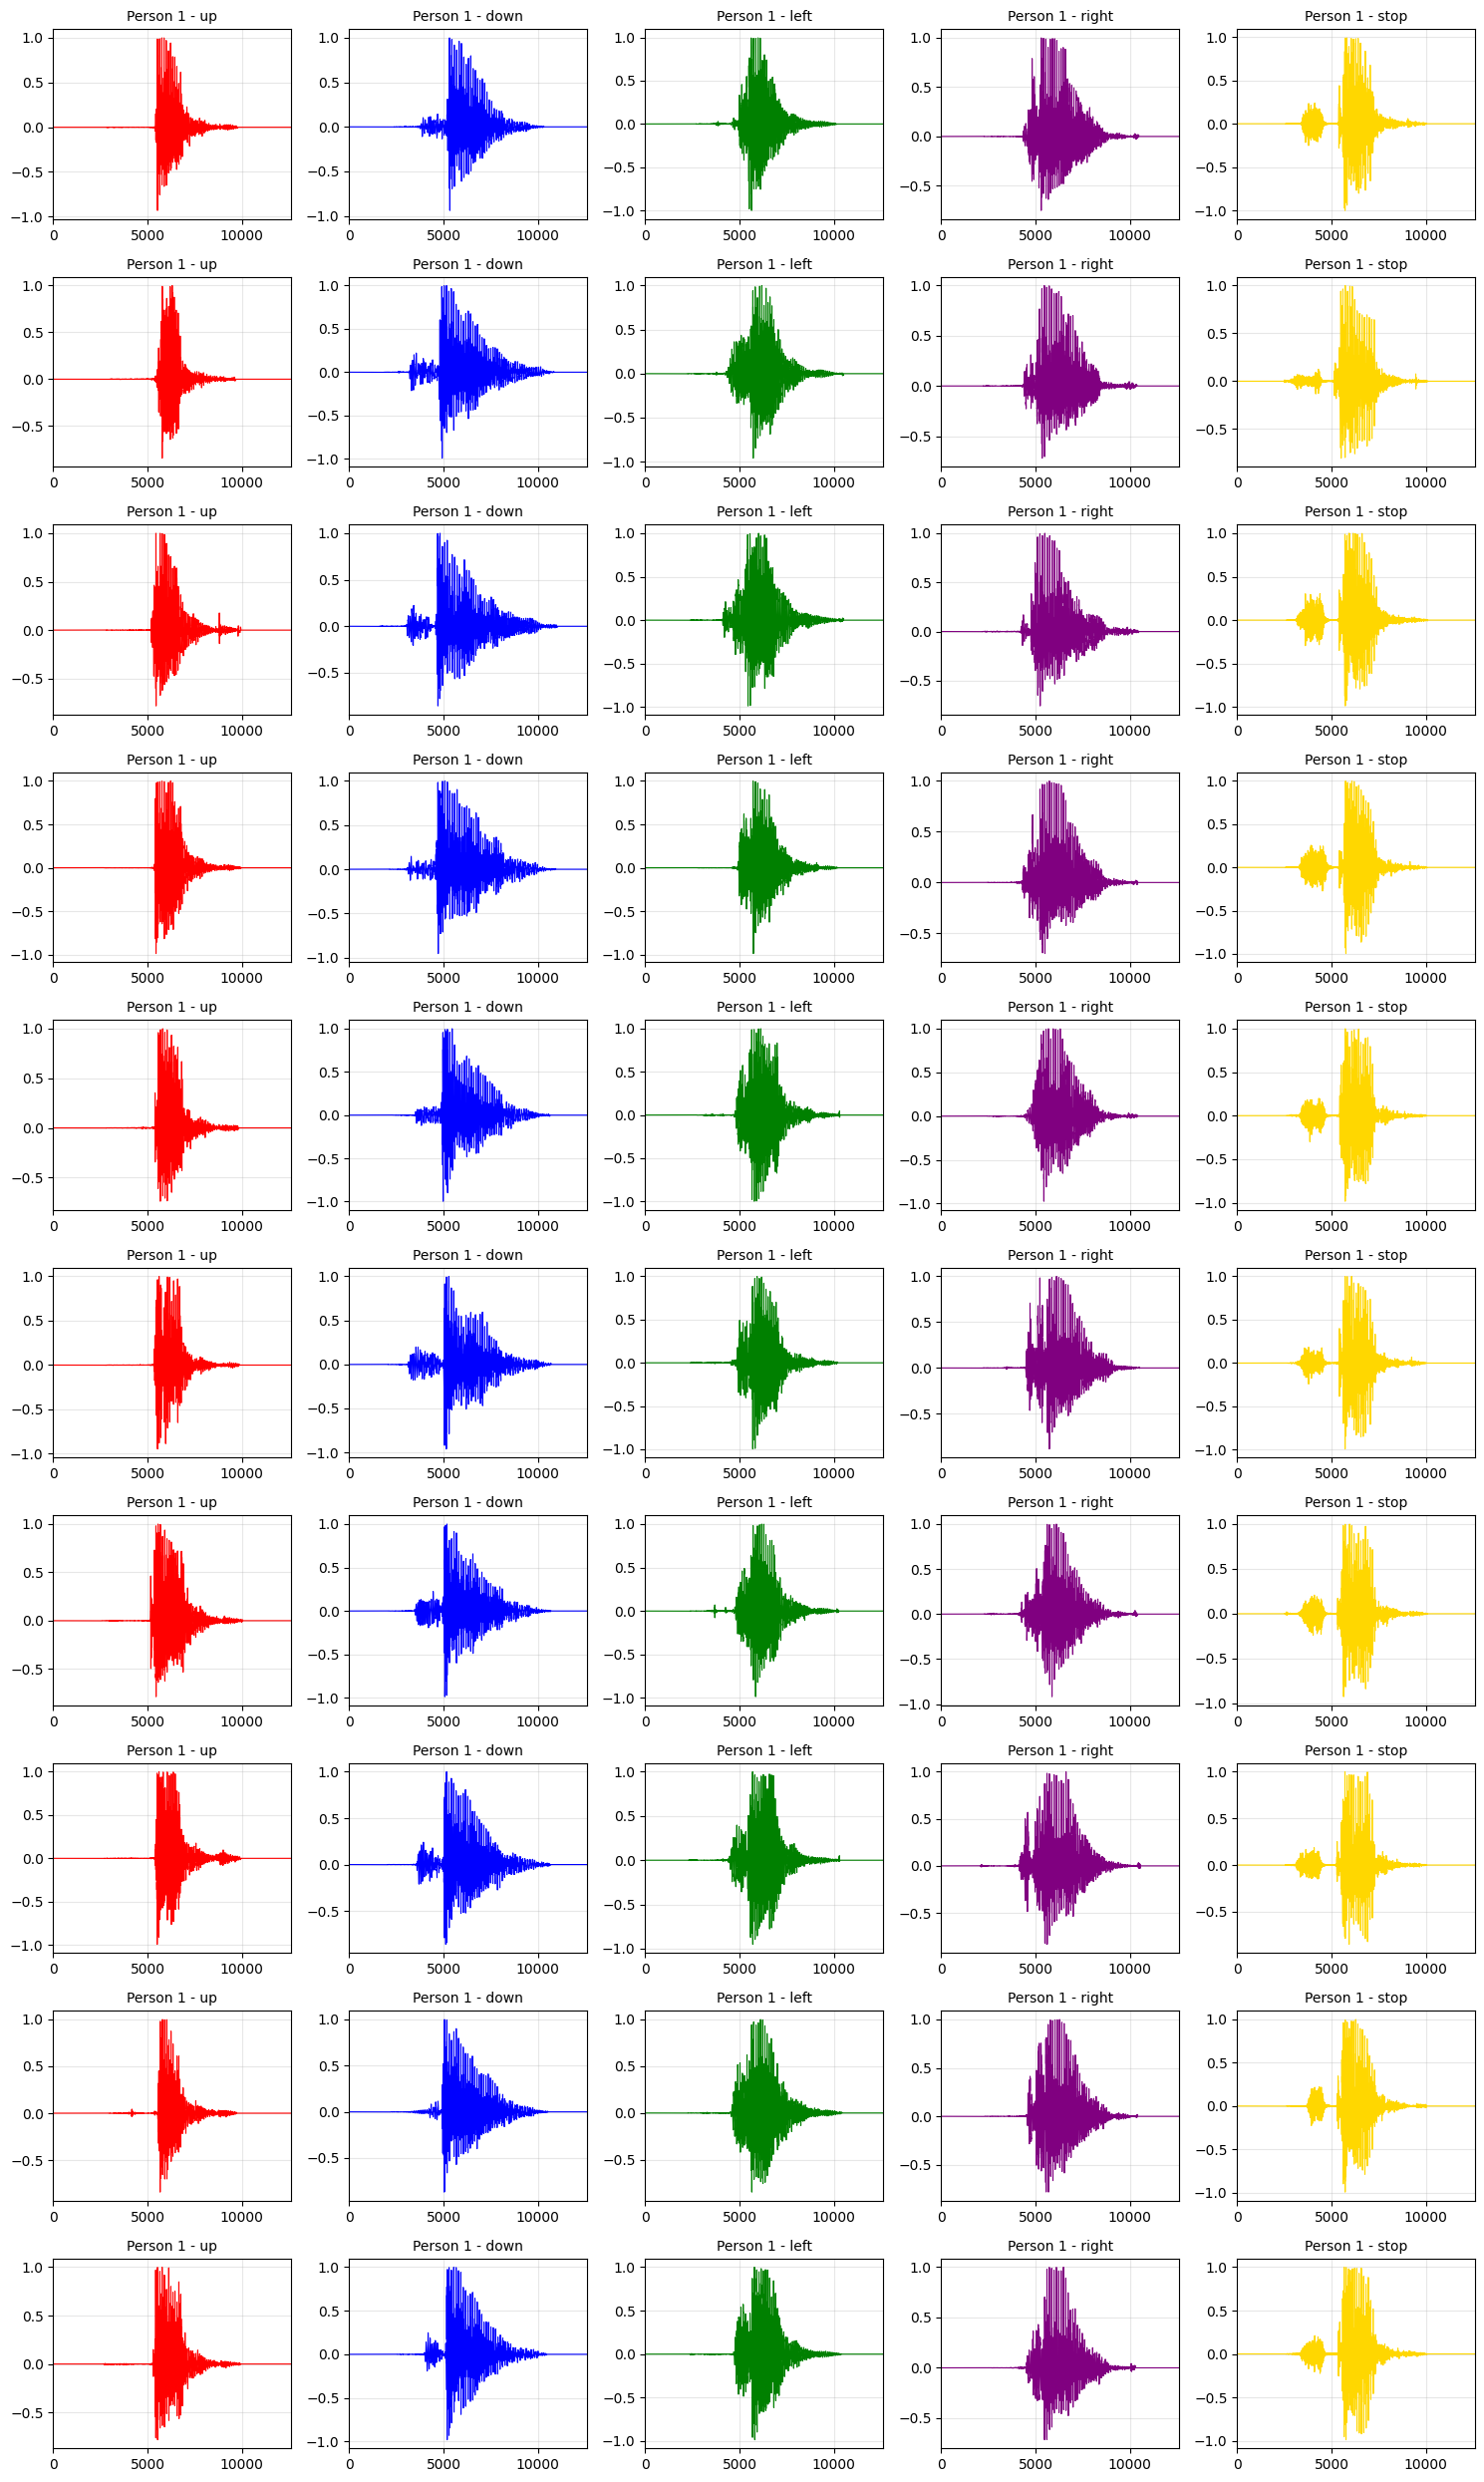

Processing: Person 1 - up


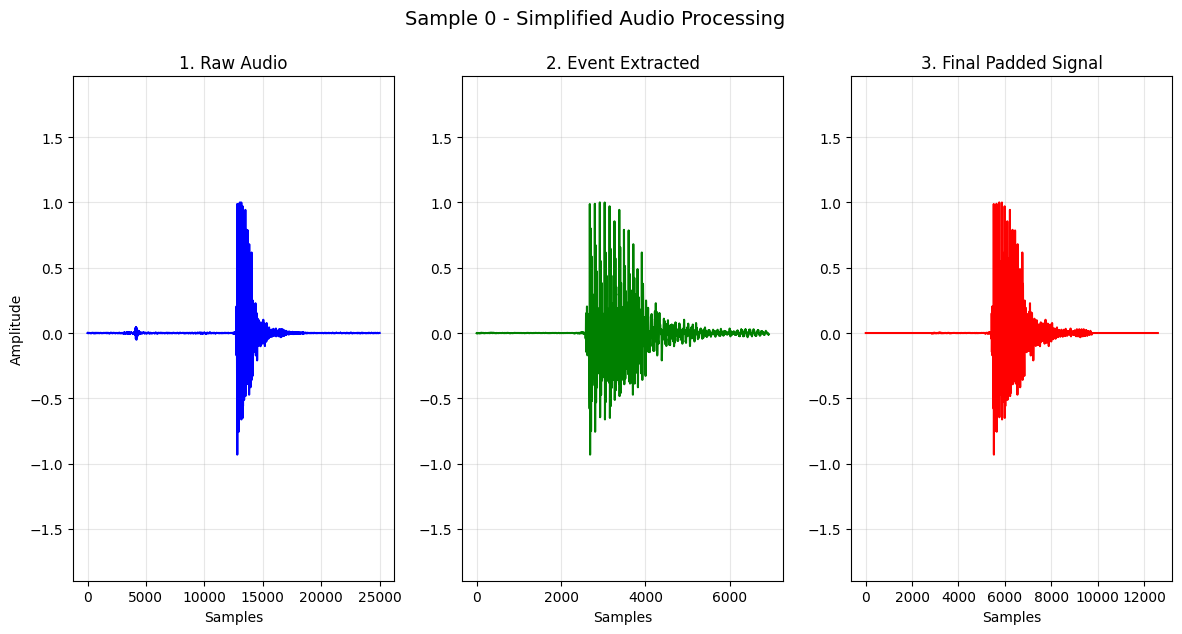

Processing: Person 4 - up


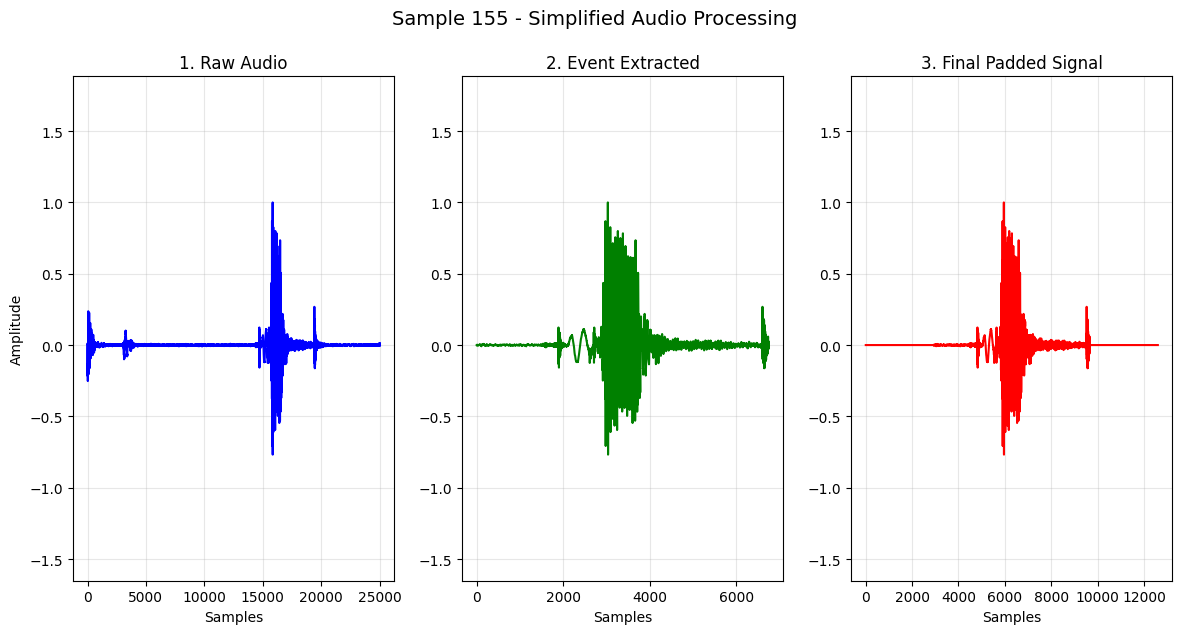

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from math import ceil

# Constants
THRESHOLD = 0.02
SAMPLE_RATE = 12600
TARGET_LENGTH = 12600

def envelope(x, rate, threshold):
    """Simplified envelope detection without start/end cuts"""
    win_length = int(rate / 2)
    env = np.convolve(np.abs(x), np.ones(win_length) / win_length, mode='same')
    mask = env > threshold
    return mask

def pad_or_slice(x, target_length):
    """Pad or slice signal to target length"""
    diff = target_length - len(x)
    if diff > 0:
        return np.pad(x, (diff // 2, diff - diff // 2), mode='constant')
    else:
        start = -diff // 2
        return x[start:start + target_length]

def process_signal(x, sample_index=0, show_plot=False):
    """Simplified processing: event extraction -> padding"""
    # Event extraction
    mask = envelope(x, SAMPLE_RATE, THRESHOLD)
    if np.any(mask):
        idx = np.where(mask)[0]
        x_event = x[idx[0]: idx[-1] + 1]
    else:
        x_event = x.copy()
    
    # Padding to target length
    x_padded = pad_or_slice(x_event, TARGET_LENGTH)

    if show_plot:
        visualize_sample(x, x_event, x_padded, sample_index)
    
    return x_padded

def visualize_sample(sample, extracted, padded, sample_index):
    """Visualize the simplified processing steps"""
    plt.figure(figsize=(12, 6))

    all_vals = np.concatenate([sample, extracted, padded])
    y_min, y_max = np.min(all_vals), np.max(all_vals)
    y_margin = 0.5 * (y_max - y_min)
    y_limits = (y_min - y_margin, y_max + y_margin)

    plt.subplot(1, 3, 1)
    plt.plot(sample, color='blue')
    plt.title("1. Raw Audio")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.ylim(y_limits)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(extracted, color='green')
    plt.title("2. Event Extracted")
    plt.xlabel("Samples")
    plt.ylim(y_limits)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(padded, color='red')
    plt.title("3. Final Padded Signal")
    plt.xlabel("Samples")
    plt.ylim(y_limits)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f"Sample {sample_index} - Simplified Audio Processing", fontsize=14, y=1.05)
    plt.show()

def process_all():
    """Process all audio data and save ONLY processed signals"""
    os.makedirs("processed_data", exist_ok=True)
    
    # Load raw data
    audio_data = np.load("npy_data/audio_data.npy", allow_pickle=True)
    
    # Process all signals
    processed_list = [process_signal(sample) for sample in audio_data]
    
    # Save ONLY processed data
    np.save("processed_data/processed_signals.npy", np.array(processed_list))
    
    print(f"Saved {len(processed_list)} processed samples")
    return processed_list

def plot_person_processed(person_ids_to_plot):
    """Plot processed signals for specific person(s)"""
    # Load processed signals
    processed_signals = np.load("processed_data/processed_signals.npy")
    
    # Load metadata from ORIGINAL location
    person_ids = np.load("npy_data/person_ids.npy")
    commands = np.load("npy_data/commands.npy")
    
    # Color mapping
    color_map = {
        'up': 'red',
        'down': 'blue',
        'left': 'green',
        'right': 'purple',
        'stop': 'gold'
    }
    
    # Make sure it's a list
    if isinstance(person_ids_to_plot, int):
        person_ids_to_plot = [person_ids_to_plot]
    
    # Find indices for selected persons
    selected = []
    for i in range(len(processed_signals)):
        if person_ids[i] in person_ids_to_plot:
            selected.append(i)
    
    # Plot
    cols = 5
    rows = (len(selected) + cols - 1) // cols
    
    plt.figure(figsize=(cols * 3, rows * 2.5))
    
    for plot_idx, data_idx in enumerate(selected):
        plt.subplot(rows, cols, plot_idx + 1)
        
        command = commands[data_idx]
        color = color_map.get(command, 'black')
        
        plt.plot(processed_signals[data_idx], color=color, linewidth=0.8)
        plt.title(f"Person {person_ids[data_idx]} - {command}", fontsize=10)
        plt.xlim(0, TARGET_LENGTH)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_indices(indices):
    """Visualize preprocessing steps for specific indices"""
    audio_data = np.load("npy_data/audio_data.npy", allow_pickle=True)
    person_ids = np.load("npy_data/person_ids.npy")
    commands = np.load("npy_data/commands.npy")
    
    for i in indices:
        if i < 0 or i >= len(audio_data):
            print(f"Index {i} is out of range. Skipping.")
            continue
        print(f"Processing: Person {person_ids[i]} - {commands[i]}")
        process_signal(audio_data[i], sample_index=i, show_plot=True)

if __name__ == "__main__":
    # Process and save all
    process_all()
    
    # Visualize person 1's processed signals
    plot_person_processed(1)
    #plot_person_processed(2)
    #plot_person_processed(3)
    #plot_person_processed(4)
    #plot_person_processed(5)
    #plot_person_processed(6)
    #plot_person_processed(7)

    # Visualize preprocessing steps for specific samples
    visualize_indices([0, 155])

## FFT Implementation

Saved FFT data for 350 samples → processed_data/fft_features/fft_data.npy
FFT processing complete for 350 samples.


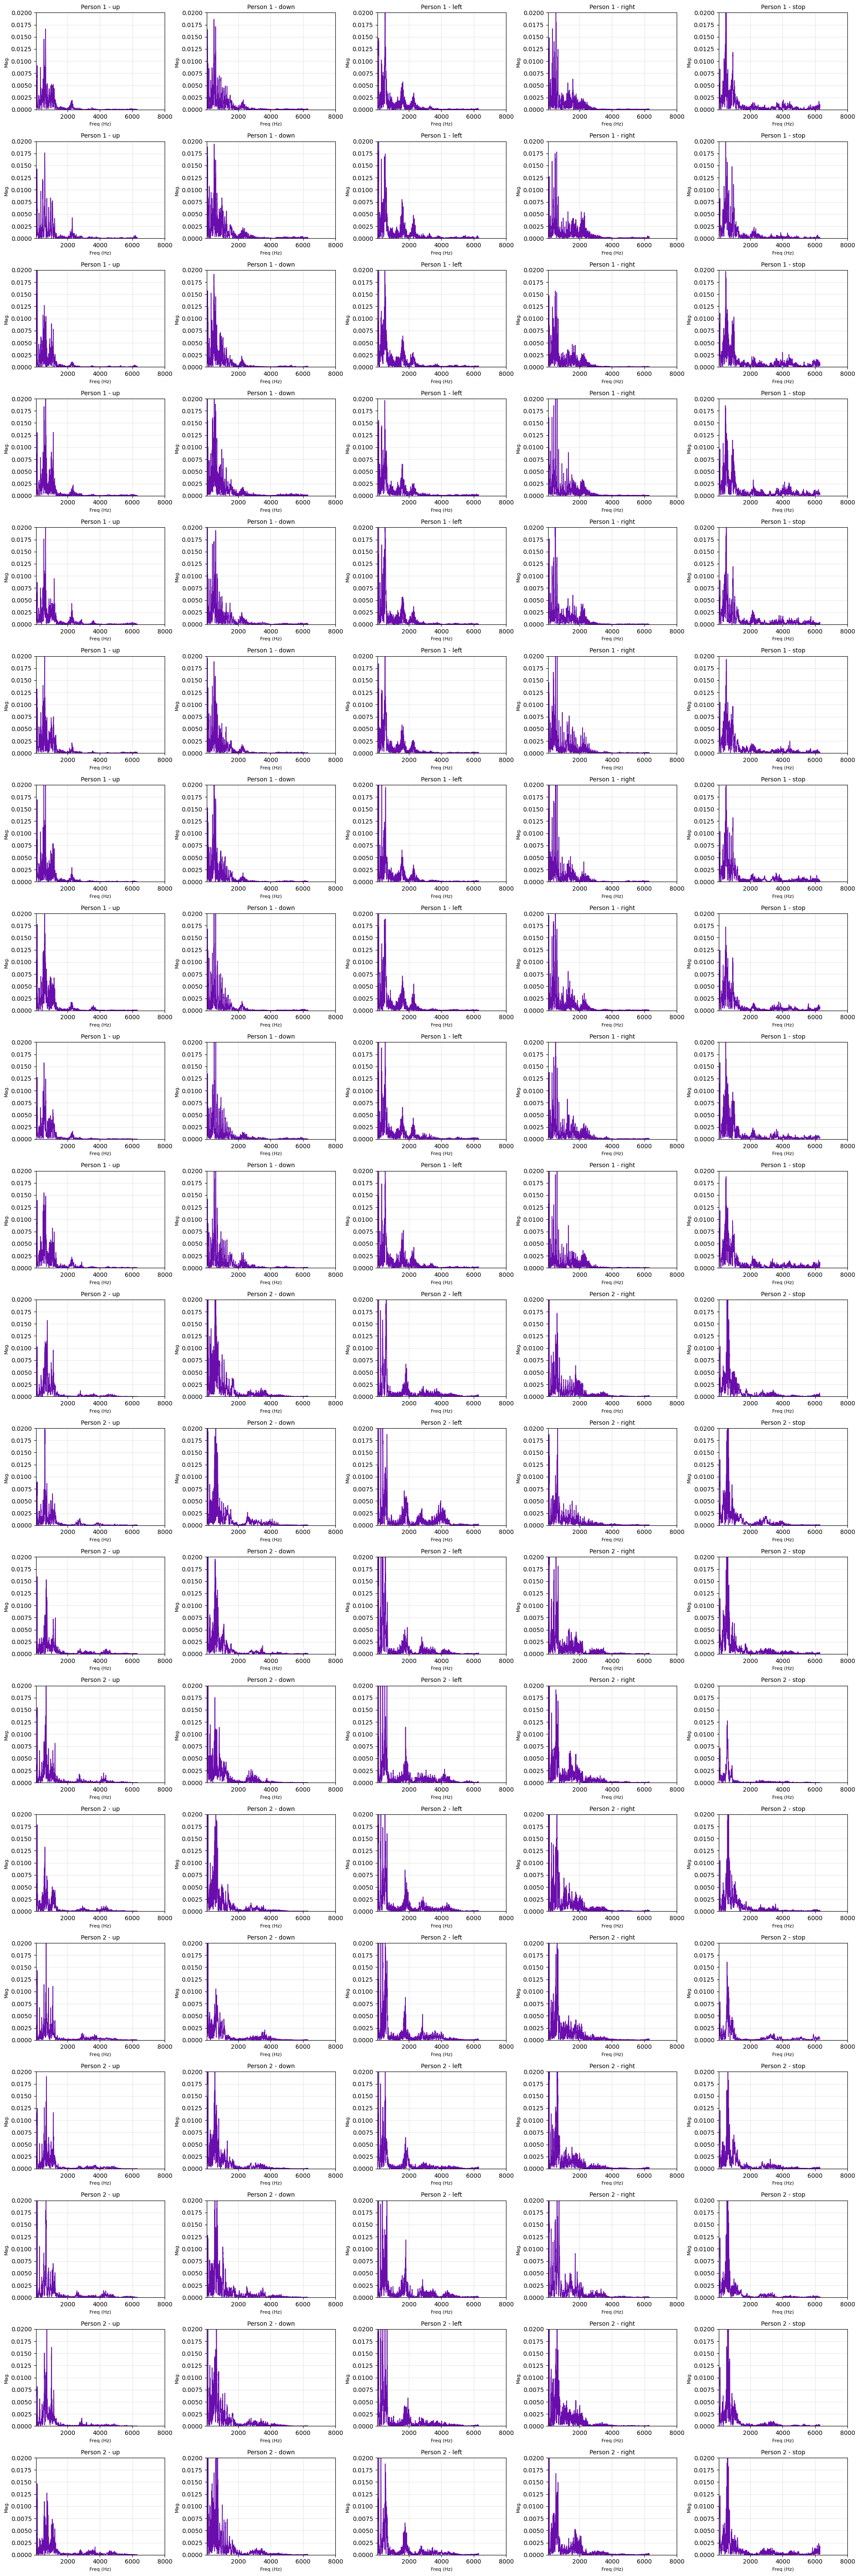

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fft import fft
import math

# Config
MIN_FREQ = 50
GRID_COLS = 5
Y_LIMITS = (0, 0.02)

def compute_fft(sample, Fs=12600, min_freq=MIN_FREQ):
    n = len(sample)
    yf = fft(sample)
    freq = np.fft.fftfreq(n, d=1/Fs)[:n//2]
    mag = (2.0 / n) * np.abs(yf[:n//2])
    mask = freq > min_freq
    return freq[mask], mag[mask]

def save_fft_data(samples, path, Fs=12600, min_freq=MIN_FREQ):
    fft_data = [dict(freq=f, magnitude=m) for x in samples 
                for f, m in [compute_fft(x, Fs, min_freq)]]
    np.save(path, np.array(fft_data, dtype=object))
    print(f"Saved FFT data for {len(fft_data)} samples → {path}")

def plot_fft_grid(fft_data, person_ids, commands, selected_indices, y_limits=Y_LIMITS, cols=GRID_COLS):
    total = len(selected_indices)
    rows = math.ceil(total / cols)
    plt.figure(figsize=(cols * 4, rows * 3))
    
    for plot_idx, data_idx in enumerate(selected_indices):
        ax = plt.subplot(rows, cols, plot_idx + 1)
        ax.plot(fft_data[data_idx]['freq'], fft_data[data_idx]['magnitude'], 
               color='#6a0dad', lw=1.2)
        ax.set_title(f"Person {person_ids[data_idx]} - {commands[data_idx]}", fontsize=10)
        ax.set_xlabel("Freq (Hz)", fontsize=8)
        ax.set_ylabel("Mag.", fontsize=8)
        ax.set_xlim(MIN_FREQ, 8000)
        ax.set_ylim(*y_limits)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_person_fft(person_ids_to_plot):
    # Load FFT data
    fft_data = np.load("processed_data/fft_features/fft_data.npy", allow_pickle=True)
    
    # Load metadata from original location
    person_ids = np.load("npy_data/person_ids.npy")
    commands = np.load("npy_data/commands.npy")
    
    # Make sure it's a list
    if isinstance(person_ids_to_plot, int):
        person_ids_to_plot = [person_ids_to_plot]
    
    # Find indices for selected persons
    selected = []
    for i in range(len(fft_data)):
        if person_ids[i] in person_ids_to_plot:
            selected.append(i)
    
    plot_fft_grid(fft_data, person_ids, commands, selected)

def process_fft():
    samples = np.load("processed_data/processed_signals.npy", allow_pickle=True)
    os.makedirs("processed_data/fft_features", exist_ok=True)
    out_path = "processed_data/fft_features/fft_data.npy"
    save_fft_data(samples, out_path)
    print(f"FFT processing complete for {len(samples)} samples.")

# Run
if __name__ == "__main__":
    # Process FFT for all samples
    process_fft()
    
    # Plot FFT for person 1
    #plot_person_fft(1)
    
    # Plot FFT for multiple persons
    plot_person_fft([1,2])

## Feature Extraction from FFT and Dimentionality Reduction LDA

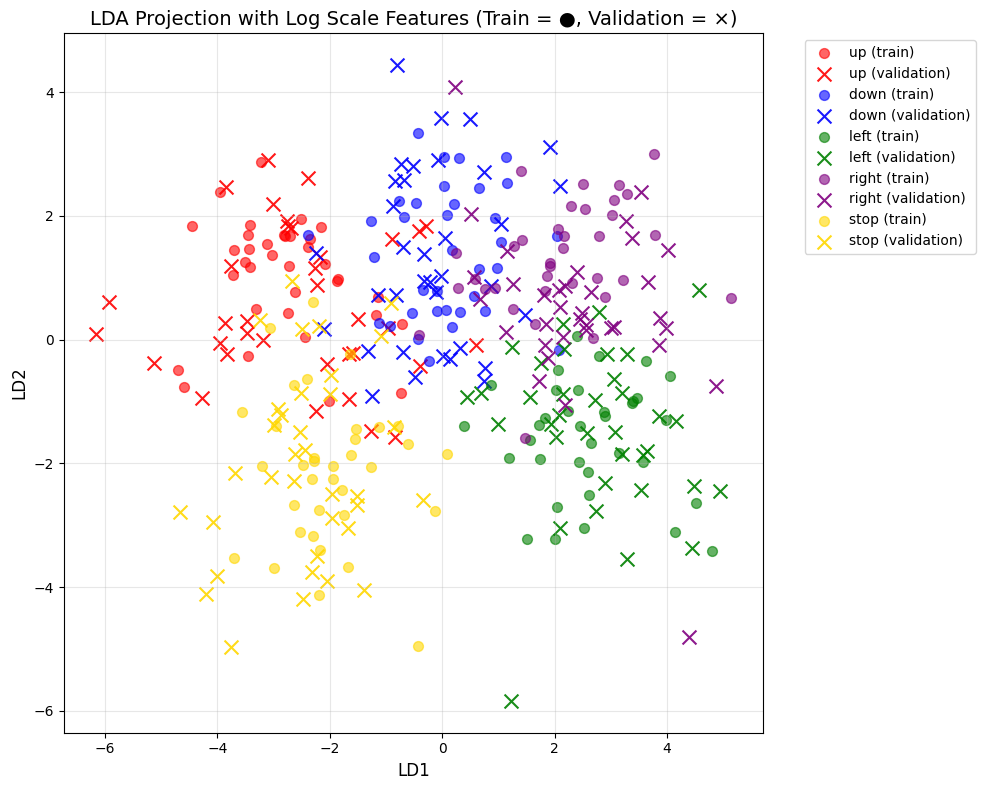

Number of features per sample: 36
Training samples: 175
Validation samples: 175
Features per ROI: 4 (log mean, log std, log max, log energy)
Total ROIs: 9


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
import os
# Load FFT data and metadata
fft_data = np.load("processed_data/fft_features/fft_data.npy", allow_pickle=True)
person_ids = np.load("npy_data/person_ids.npy")
commands = np.load("npy_data/commands.npy")
# Create label mapping
label_map = {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'stop': 4}
# Define ROIs
rois = [
    (50, 550), (550, 800), (800, 1050), 
    (1200, 1550), (1550, 1800), (1800, 2050),  
    (2050, 2300), (5800, 6000), (6000, 6300)
]
# Extract features
features = []
labels = []
for idx, sample in enumerate(fft_data):
    freq = sample['freq']
    mag = sample['magnitude']
    sample_features = []
    
    for min_f, max_f in rois:
        roi_mask = (freq >= min_f) & (freq < max_f)
        roi_mag = mag[roi_mask]
        
        if roi_mag.size > 0:
            peaks, _ = find_peaks(roi_mag, height=0.001)
            
            # Apply log scale to all features
            mean_val = np.mean(roi_mag)
            std_val = np.std(roi_mag)
            max_val = np.max(roi_mag)
            energy_val = np.sum(roi_mag**2)
            
            # Add small epsilon to avoid log(0)
            eps = 1e-10
            sample_features.append(np.log(mean_val + eps))
            sample_features.append(np.log(std_val + eps))
            sample_features.append(np.log(max_val + eps))
            sample_features.append(np.log(energy_val + eps))
        else:
            # For empty ROIs, use log of epsilon
            sample_features.extend([np.log(1e-10)] * 4)
    
    features.append(sample_features)
    labels.append(label_map[commands[idx]])
# Convert and split
X = np.array(features)
y = np.array(labels)
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
# LDA directly (no PCA)
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_validation_lda = lda.transform(X_validation_scaled)
# Save
os.makedirs("processed_data/lda_features", exist_ok=True)
np.save("processed_data/lda_features/X_train_lda.npy", X_train_lda)
np.save("processed_data/lda_features/X_validation_lda.npy", X_validation_lda)
np.save("processed_data/lda_features/y_train.npy", y_train)
np.save("processed_data/lda_features/y_validation.npy", y_validation)
# Save scaler and LDA for later use
import joblib
joblib.dump(scaler, "processed_data/lda_features/scaler.pkl")
joblib.dump(lda, "processed_data/lda_features/lda.pkl")
# Plot
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'gold']
commands_list = ['up', 'down', 'left', 'right', 'stop']
for i in range(5):
    # Train points
    train_mask = y_train == i
    plt.scatter(X_train_lda[train_mask, 0], X_train_lda[train_mask, 1],
                color=colors[i], label=f"{commands_list[i]} (train)", 
                alpha=0.6, marker='o', s=50)
    
     #Validation points
    validation_mask = y_validation == i
    plt.scatter(X_validation_lda[validation_mask, 0], X_validation_lda[validation_mask, 1],
                color=colors[i], label=f"{commands_list[i]} (validation)", 
                alpha=0.9, marker='x', s=100)
plt.title("LDA Projection with Log Scale Features (Train = ●, Validation = ×)", fontsize=14)
plt.xlabel("LD1", fontsize=12)
plt.ylabel("LD2", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
# Print classification report
print(f"Number of features per sample: {X.shape[1]}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_validation)}")
print(f"Features per ROI: 4 (log mean, log std, log max, log energy)")
print(f"Total ROIs: {len(rois)}")

## Classifier 1: k-NN Development (Hyperparameter selection)


K-FOLD CROSS-VALIDATION RESULTS
Best K: 11
Mean Accuracy at K=11: 0.754 ± 0.033


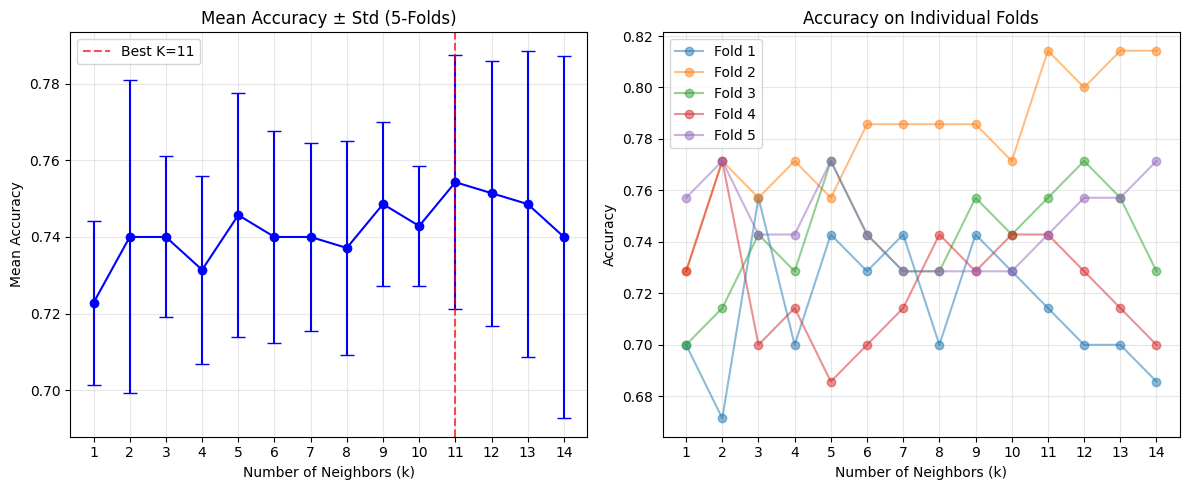

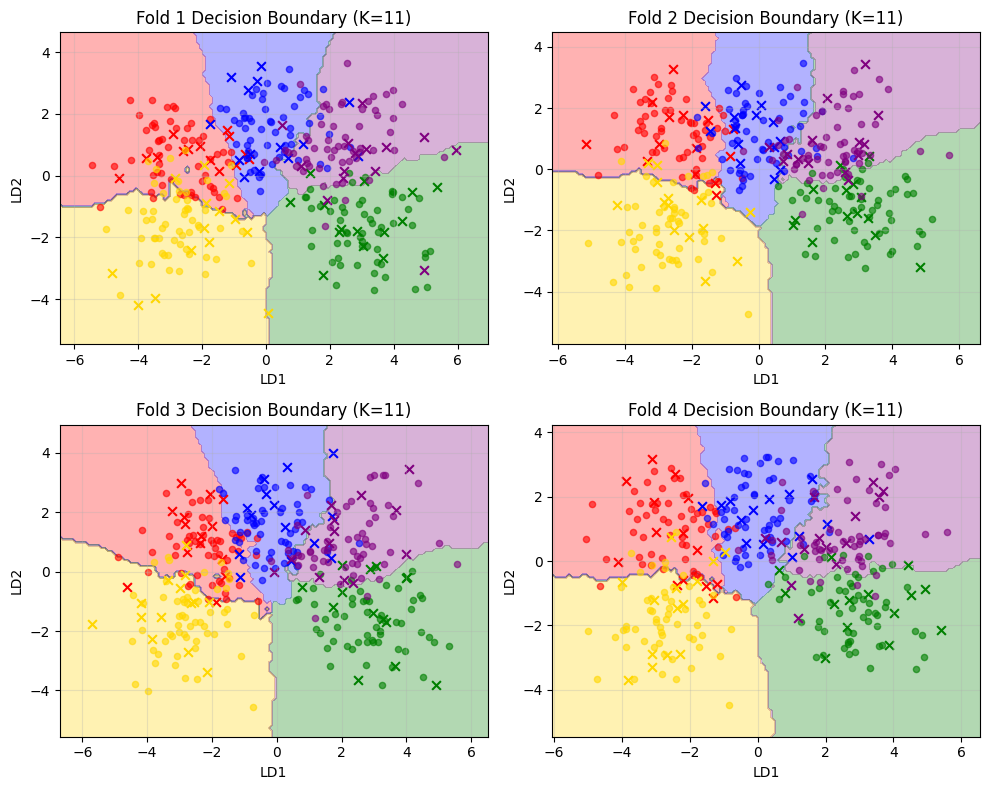

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import os

# Load data
fft_data = np.load("processed_data/fft_features/fft_data.npy", allow_pickle=True)
commands = np.load("npy_data/commands.npy")

# Define labels and regions of interest (ROIs) for feature extraction
label_map = {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'stop': 4}
rois = [
    (50, 500), (550, 800), (800, 1050),
    (1200, 1550), (1550, 1800), (1800, 2050),
    (2050, 2300), (5800, 6000), (6000, 6300)
]

# Extract features from FFT data based on ROIs
features = []
labels = []
for idx, sample in enumerate(fft_data):
    freq = sample['freq']
    mag = sample['magnitude']
    sample_features = []
    
    for min_f, max_f in rois:
        roi_mask = (freq >= min_f) & (freq < max_f)
        roi_mag = mag[roi_mask]
        
        eps = 1e-10
        if roi_mag.size > 0:
            sample_features.append(np.log(np.mean(roi_mag) + eps))
            sample_features.append(np.log(np.std(roi_mag) + eps))
            sample_features.append(np.log(np.max(roi_mag) + eps))
            sample_features.append(np.log(np.sum(roi_mag**2) + eps))
        else:
            sample_features.extend([np.log(eps)] * 4)
    
    features.append(sample_features)
    labels.append(label_map[commands[idx]])

X = np.array(features)
y = np.array(labels)

# Setup K-Fold cross-validation
n_splits = 5
# Using K-Fold is a robust method for a "statistical meaningful evalution" on smaller datasets.
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
k_range = range(1, 15)

all_accuracies = []
split_data = [] # Store data from each fold for plotting

# Run cross-validation loop
for fold_idx, (train_indices, test_indices) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lda = LDA(n_components=2)
    X_train_lda = lda.fit_transform(X_train_scaled, y_train)
    X_test_lda = lda.transform(X_test_scaled)
    
    split_data.append((X_train_lda, X_test_lda, y_train, y_test))
    
    fold_accuracies = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_lda, y_train)
        y_pred = knn.predict(X_test_lda)
        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(accuracy)
    
    all_accuracies.append(fold_accuracies)

# Calculate and report results
all_accuracies = np.array(all_accuracies)
mean_accuracies = np.mean(all_accuracies, axis=0)
std_accuracies = np.std(all_accuracies, axis=0)

best_k_idx = np.argmax(mean_accuracies)
best_k = k_range[best_k_idx]
best_mean_acc = mean_accuracies[best_k_idx]
best_std_acc = std_accuracies[best_k_idx]

print(f"\n" + "="*50)
print(f"K-FOLD CROSS-VALIDATION RESULTS")
print(f"="*50)
print(f"Best K: {best_k}")
print(f"Mean Accuracy at K={best_k}: {best_mean_acc:.3f} ± {best_std_acc:.3f}")

# Plot accuracy results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.errorbar(k_range, mean_accuracies, yerr=std_accuracies, fmt='bo-', capsize=5)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_k}')
plt.title(f'Mean Accuracy ± Std ({n_splits}-Folds)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

plt.subplot(1, 2, 2)
for i in range(n_splits):
    plt.plot(k_range, all_accuracies[i], 'o-', alpha=0.5, label=f'Fold {i+1}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy on Individual Folds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()


# Plot decision boundaries for the first 4 folds
colors = ['red', 'blue', 'green', 'purple', 'gold']
commands_list = ['up', 'down', 'left', 'right', 'stop']
cmap = ListedColormap(colors)
num_classes = len(commands_list)

plt.figure(figsize=(10, 8))

for i in range(min(4, n_splits)):
    ax = plt.subplot(2, 2, i + 1)
    
    X_train_lda, X_test_lda, y_train, y_test = split_data[i]
    
    # Create mesh for decision boundary
    h = 0.1
    x_min, x_max = np.concatenate((X_train_lda[:, 0], X_test_lda[:, 0])).min() - 1, np.concatenate((X_train_lda[:, 0], X_test_lda[:, 0])).max() + 1
    y_min, y_max = np.concatenate((X_train_lda[:, 1], X_test_lda[:, 1])).min() - 1, np.concatenate((X_train_lda[:, 1], X_test_lda[:, 1])).max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Train a KNN with the overall best K on this fold's training data
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train_lda, y_train)
    
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=len(commands_list)-1)
    
    # Plot training and testing points
    for j in range(num_classes):
        train_mask = y_train == j
        ax.scatter(X_train_lda[train_mask, 0], X_train_lda[train_mask, 1],
                   color=colors[j], alpha=0.6, marker='o', s=20, label=f"{commands_list[j]} (train)")
        
        test_mask = y_test == j
        ax.scatter(X_test_lda[test_mask, 0], X_test_lda[test_mask, 1],
                   color=colors[j], alpha=1.0, marker='x', s=40, label=f"{commands_list[j]} (test)")

    ax.set_title(f'Fold {i+1} Decision Boundary (K={best_k})')
    ax.set_xlabel('LD1')
    ax.set_ylabel('LD2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## KNN Model training on all 350 voice commands

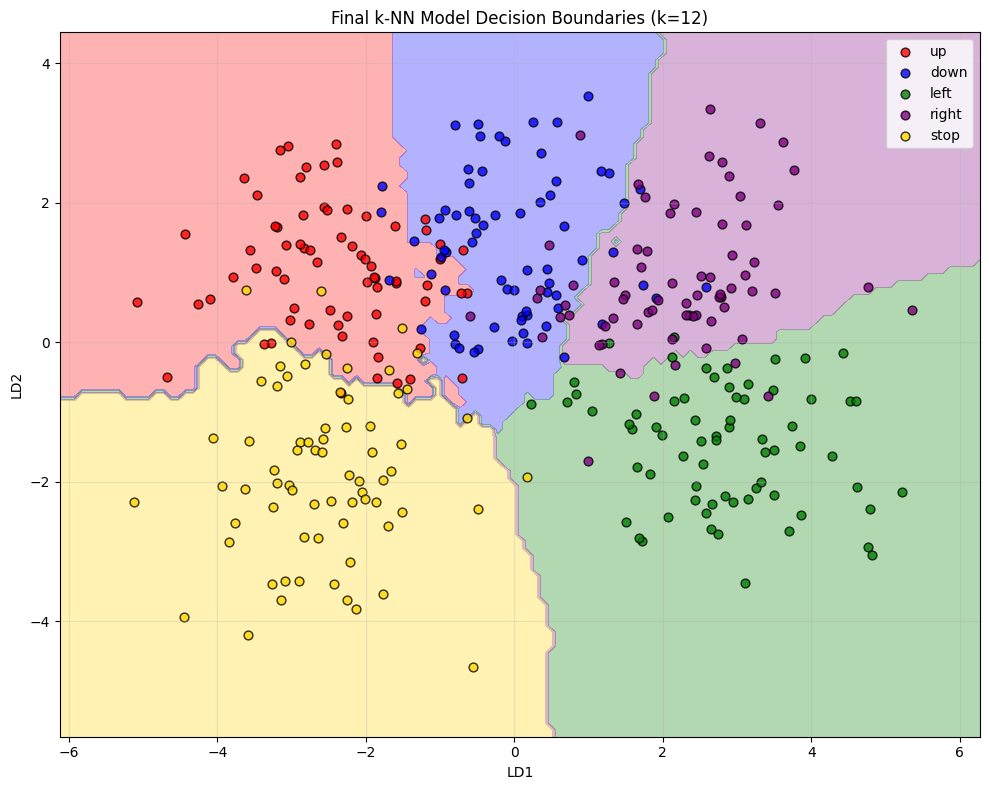

Pipeline Complete. Final models are saved and ready for the test set.


In [7]:
import numpy as np
import os
import joblib
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Configuration
DEV_AUDIO_DIR = "recordings"
BEST_K = 12
SAMPLE_RATE = 12600
TARGET_LENGTH = 12600
THRESHOLD = 0.02
ROIS = [
    (50, 550), (550, 800), (800, 1050),
    (1200, 1550), (1550, 1800), (1800, 2050),
    (2050, 2300), (5800, 6000), (6000, 6300)
]
COMMANDS_TO_INCLUDE = ['up', 'down', 'left', 'right', 'stop']
FINAL_MODELS_DIR = "final_models"


def preprocess_audio(data, sr, target_sr, threshold, target_length):
    if target_sr and sr != target_sr:
        data = signal.resample(data, int(len(data) * (target_sr / sr)))
    if np.max(np.abs(data)) > 0:
        data = data.astype(np.float32) / np.max(np.abs(data))
    
    win_length = int(target_sr / 2)
    env = np.convolve(np.abs(data), np.ones(win_length) / win_length, mode='same')
    mask = env > threshold
    
    if np.any(mask):
        idx = np.where(mask)[0]
        data = data[idx[0]: idx[-1] + 1]
    
    diff = target_length - len(data)
    if diff > 0:
        return np.pad(data, (diff // 2, diff - diff // 2), mode='constant')
    else:
        start = -diff // 2
        return data[start:start + target_length]

def extract_features(processed_signals, sr, rois):
    features = []
    for signal_data in processed_signals:
        n = len(signal_data)
        yf = fft(signal_data)
        freq = np.fft.fftfreq(n, d=1/sr)[:n//2]
        mag = (2.0 / n) * np.abs(yf[:n//2])
        
        sample_features = []
        for min_f, max_f in rois:
            roi_mask = (freq >= min_f) & (freq < max_f)
            roi_mag = mag[roi_mask]
            
            eps = 1e-10
            if roi_mag.size > 0:
                sample_features.append(np.log(np.mean(roi_mag) + eps))
                sample_features.append(np.log(np.std(roi_mag) + eps))
                sample_features.append(np.log(np.max(roi_mag) + eps))
                sample_features.append(np.log(np.sum(roi_mag**2) + eps))
            else:
                sample_features.extend([np.log(eps)] * 4)
        features.append(sample_features)
    return np.array(features)

def plot_final_decision_boundary(X_lda, y, knn_model, commands_list):
    plt.figure(figsize=(10, 8))
    
    full_color_map = {'up': 'red', 'down': 'blue', 'left': 'green', 'right': 'purple', 'stop': 'gold'}
    colors_to_use = [full_color_map.get(cmd, 'black') for cmd in commands_list]
    cmap = ListedColormap(colors_to_use)
    
    h = 0.1
    x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
    y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=len(commands_list)-1)
    
    for i, command in enumerate(commands_list):
        mask = y == i
        plt.scatter(X_lda[mask, 0], X_lda[mask, 1],
                      color=colors_to_use[i], label=command, 
                      alpha=0.8, marker='o', s=40, edgecolor='k')
    
    plt.title(f'Final k-NN Model Decision Boundaries (k={knn_model.n_neighbors})')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def train_final_model():
    # Load and Preprocess
    processed_signals, commands = [], []
    for root, _, files in os.walk(DEV_AUDIO_DIR):
        for filename in files:
            if filename.lower().endswith(".wav"):
                filepath = os.path.join(root, filename)
                sr, data = wavfile.read(filepath)
                processed_signals.append(preprocess_audio(data, sr, SAMPLE_RATE, THRESHOLD, TARGET_LENGTH))
                commands.append(filename.split('.')[-2].split('_')[-1])

    if not processed_signals:
        print(f"ERROR: No .wav files found in '{DEV_AUDIO_DIR}'.")
        return
    
    # Extract Features
    X_full_dev = extract_features(processed_signals, SAMPLE_RATE, ROIS)
    label_map = {cmd: i for i, cmd in enumerate(COMMANDS_TO_INCLUDE)}
    y_full_dev = np.array([label_map[cmd] for cmd in commands])
    
    # Train Scaler and LDA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full_dev)
    lda = LDA(n_components=2)
    X_lda = lda.fit_transform(X_scaled, y_full_dev)

    # Train Final k-NN Classifier
    knn_final = KNeighborsClassifier(n_neighbors=BEST_K)
    knn_final.fit(X_lda, y_full_dev)
    
    # Visualize the final trained model
    plot_final_decision_boundary(X_lda, y_full_dev, knn_final, COMMANDS_TO_INCLUDE)
    
    # Save all final models
    os.makedirs(FINAL_MODELS_DIR, exist_ok=True)
    joblib.dump(scaler, os.path.join(FINAL_MODELS_DIR, "scaler.pkl"))
    joblib.dump(lda, os.path.join(FINAL_MODELS_DIR, "lda.pkl"))
    joblib.dump(knn_final, os.path.join(FINAL_MODELS_DIR, "knn_model.pkl"))
    np.save(os.path.join(FINAL_MODELS_DIR, "commands_list.npy"), np.array(COMMANDS_TO_INCLUDE))
    
    print("Pipeline Complete. Final models are saved and ready for the test set.")

if __name__ == "__main__":
    train_final_model()

## Trained k-NN Model used to predict test data


                 FINAL MODEL PERFORMANCE REPORT
Test Set Size: 250 samples
Final Accuracy: 0.7240 (72.40%)

Detailed Classification Report:
              precision    recall  f1-score   support

          up       0.77      0.72      0.74        50
        down       0.64      0.60      0.62        50
        left       0.73      0.98      0.84        50
       right       0.73      0.70      0.71        50
        stop       0.76      0.62      0.68        50

    accuracy                           0.72       250
   macro avg       0.72      0.72      0.72       250
weighted avg       0.72      0.72      0.72       250



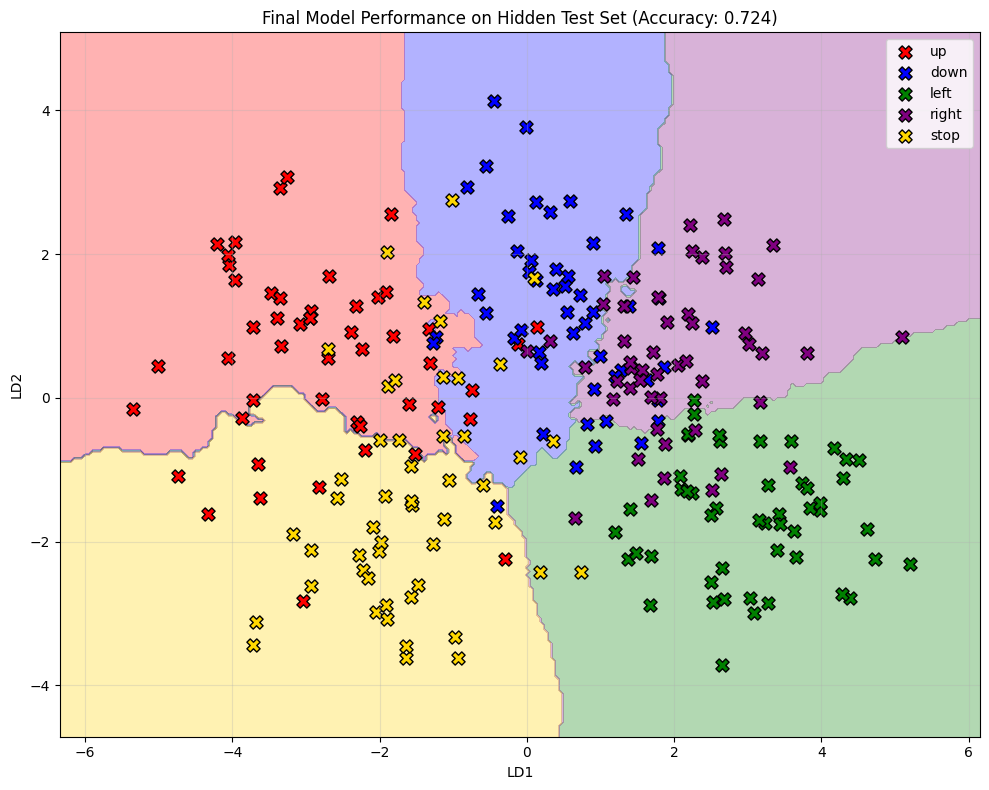

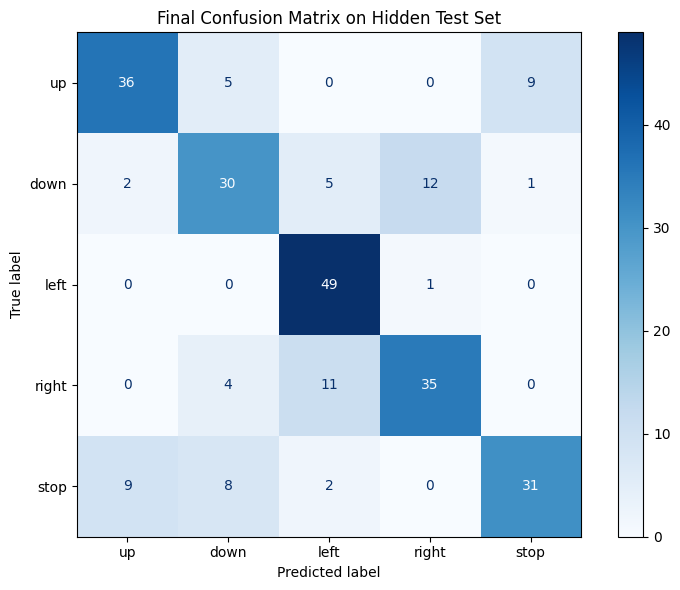

In [8]:
import numpy as np
import os
import joblib
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from matplotlib.colors import ListedColormap

# Configuration
TEST_AUDIO_DIR = "TEST"
FINAL_MODELS_DIR = "final_models"
SAMPLE_RATE = 12600
TARGET_LENGTH = 12600
THRESHOLD = 0.02
ROIS = [
    (50, 550), (550, 800), (800, 1050),
    (1200, 1550), (1550, 1800), (1800, 2050),
    (2050, 2300), (5800, 6000), (6000, 6300)
]

def preprocess_audio(data, sr, target_sr, threshold, target_length):
    if target_sr and sr != target_sr:
        data = signal.resample(data, int(len(data) * (target_sr / sr)))
    if np.max(np.abs(data)) > 0:
        data = data.astype(np.float32) / np.max(np.abs(data))
    
    win_length = int(target_sr / 2)
    env = np.convolve(np.abs(data), np.ones(win_length) / win_length, mode='same')
    mask = env > threshold
    
    if np.any(mask):
        idx = np.where(mask)[0]
        data = data[idx[0]: idx[-1] + 1]
    
    diff = target_length - len(data)
    if diff > 0:
        return np.pad(data, (diff // 2, diff - diff // 2), mode='constant')
    else:
        start = -diff // 2
        return data[start:start + target_length]

def extract_features(processed_signals, sr, rois):
    features = []
    for signal_data in processed_signals:
        n = len(signal_data)
        yf = fft(signal_data)
        freq = np.fft.fftfreq(n, d=1/sr)[:n//2]
        mag = (2.0 / n) * np.abs(yf[:n//2])
        
        sample_features = []
        for min_f, max_f in rois:
            roi_mask = (freq >= min_f) & (freq < max_f)
            roi_mag = mag[roi_mask]
            
            eps = 1e-10
            if roi_mag.size > 0:
                sample_features.append(np.log(np.mean(roi_mag) + eps))
                sample_features.append(np.log(np.std(roi_mag) + eps))
                sample_features.append(np.log(np.max(roi_mag) + eps))
                sample_features.append(np.log(np.sum(roi_mag**2) + eps))
            else:
                sample_features.extend([np.log(eps)] * 4)
        features.append(sample_features)
    return np.array(features)

def plot_test_set_on_boundaries(knn_model, X_test_lda, y_test_true, commands_list, final_accuracy):
    plt.figure(figsize=(10, 8))
    
    full_color_map = {'up': 'red', 'down': 'blue', 'left': 'green', 'right': 'purple', 'stop': 'gold'}
    colors_to_use = [full_color_map.get(cmd, 'black') for cmd in commands_list]
    cmap = ListedColormap(colors_to_use)
    
    h = 0.05
    x_min, x_max = X_test_lda[:, 0].min() - 1, X_test_lda[:, 0].max() + 1
    y_min, y_max = X_test_lda[:, 1].min() - 1, X_test_lda[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=len(commands_list)-1)
    
    for i, command in enumerate(commands_list):
        mask = y_test_true == i
        plt.scatter(
            X_test_lda[mask, 0], X_test_lda[mask, 1],
            c=colors_to_use[i], label=command,
            marker='X', s=90, edgecolor='k', linewidth=1
        )
    
    plt.title(f'Final Model Performance on Hidden Test Set (Accuracy: {final_accuracy:.3f})')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def evaluate_final_model():
    # Load models
    scaler = joblib.load(os.path.join(FINAL_MODELS_DIR, "scaler.pkl"))
    lda = joblib.load(os.path.join(FINAL_MODELS_DIR, "lda.pkl"))
    knn_model = joblib.load(os.path.join(FINAL_MODELS_DIR, "knn_model.pkl"))
    commands_list = np.load(os.path.join(FINAL_MODELS_DIR, "commands_list.npy"))

    # Process test audio
    test_signals, y_test_true_str = [], []
    for root, _, files in os.walk(TEST_AUDIO_DIR):
        for filename in files:
            if filename.lower().endswith(".wav"):
                filepath = os.path.join(root, filename)
                sr, data = wavfile.read(filepath)
                test_signals.append(preprocess_audio(data, sr, SAMPLE_RATE, THRESHOLD, TARGET_LENGTH))
                y_test_true_str.append(filename.split('.')[-2].split('_')[-1])
    
    if not test_signals:
        print(f"ERROR: No .wav files found in '{TEST_AUDIO_DIR}'.")
        return
    
    # Extract features from test data
    X_test = extract_features(test_signals, SAMPLE_RATE, ROIS)

    # Apply trained Scaler and LDA transformations
    X_test_scaled = scaler.transform(X_test)
    X_test_lda = lda.transform(X_test_scaled)
    
    # Make predictions with the final k-NN model
    y_pred_indices = knn_model.predict(X_test_lda)
    
    # Calculate and report final performance metrics
    label_map = {cmd: i for i, cmd in enumerate(commands_list)}
    y_test_true_indices = np.array([label_map[cmd] for cmd in y_test_true_str])
    
    final_accuracy = accuracy_score(y_test_true_indices, y_pred_indices)
    
    print("\n" + "="*50)
    print("                 FINAL MODEL PERFORMANCE REPORT")
    print("="*50)
    print(f"Test Set Size: {len(y_test_true_indices)} samples")
    print(f"Final Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print("="*50)
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_test_true_indices, y_pred_indices, 
                                target_names=commands_list))
    
    # Display the final plots
    plot_test_set_on_boundaries(knn_model, X_test_lda, y_test_true_indices, commands_list, final_accuracy)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_test_true_indices, y_pred_indices, 
        display_labels=commands_list, 
        cmap='Blues',
        ax=ax
    )
    plt.title("Final Confusion Matrix on Hidden Test Set")
    ax.grid(False)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate_final_model()

## Classifier 2: SVM (Linear Kernel) Development (Hyperparameter selection)


K-FOLD CROSS-VALIDATION RESULTS (Linear SVM)
Best C: 1
Mean Accuracy at C=1: 0.766 ± 0.033


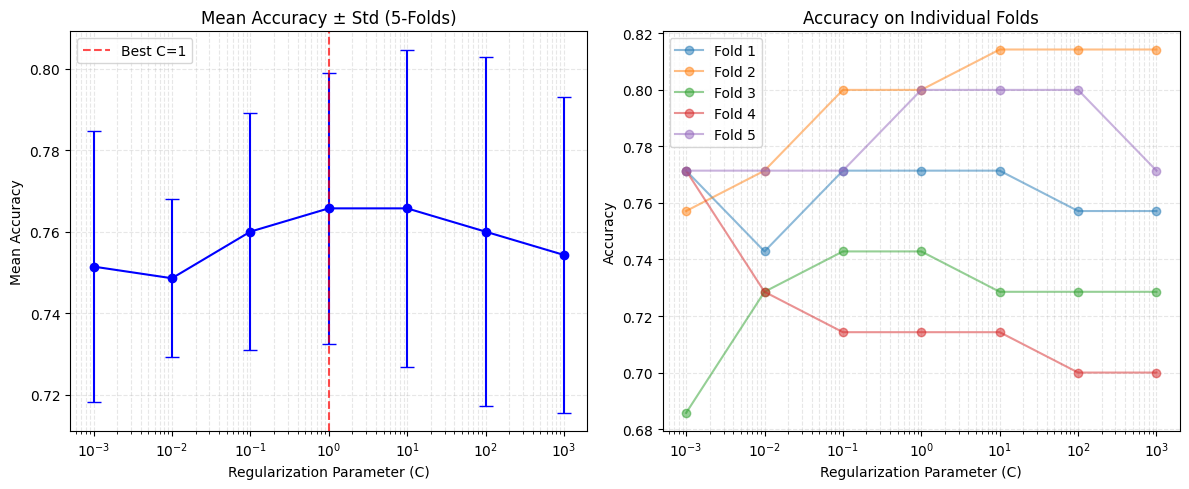

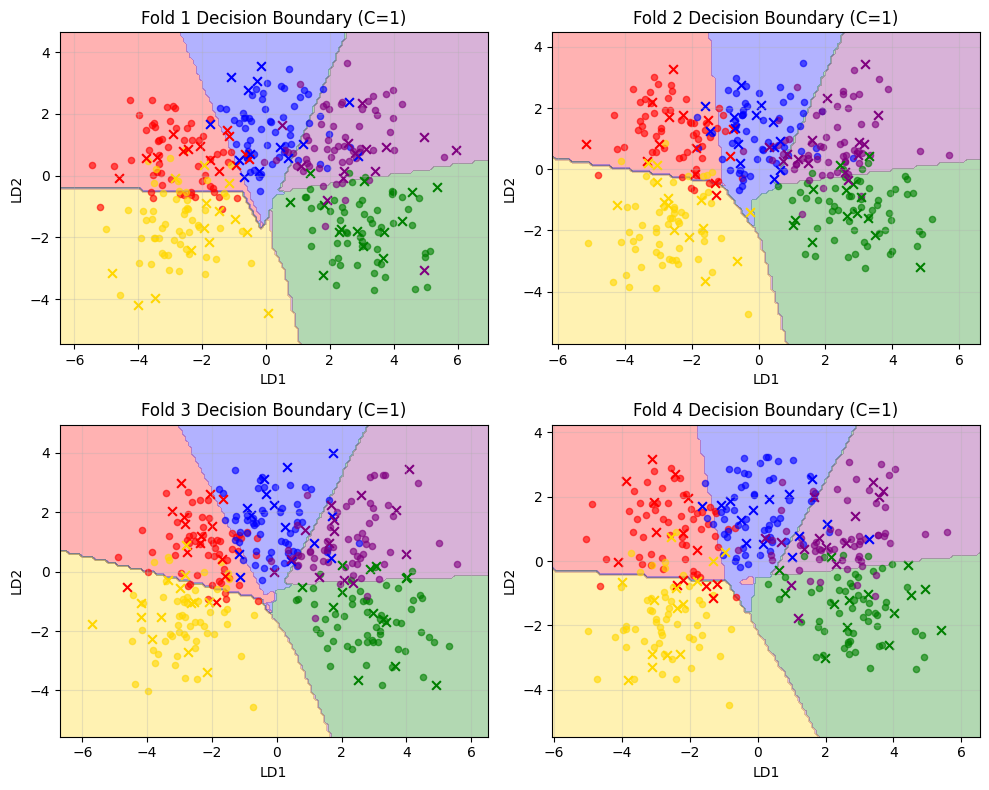

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import os

# Load data and extract features
fft_data = np.load("processed_data/fft_features/fft_data.npy", allow_pickle=True)
commands = np.load("npy_data/commands.npy")

label_map = {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'stop': 4}
rois = [
    (50, 500), (550, 800), (800, 1050),
    (1200, 1550), (1550, 1800), (1800, 2050),
    (2050, 2300), (5800, 6000), (6000, 6300)
]

features = []
labels = []
for idx, sample in enumerate(fft_data):
    freq = sample['freq']
    mag = sample['magnitude']
    sample_features = []
    
    for min_f, max_f in rois:
        roi_mask = (freq >= min_f) & (freq < max_f)
        roi_mag = mag[roi_mask]
        
        eps = 1e-10
        if roi_mag.size > 0:
            sample_features.append(np.log(np.mean(roi_mag) + eps))
            sample_features.append(np.log(np.std(roi_mag) + eps))
            sample_features.append(np.log(np.max(roi_mag) + eps))
            sample_features.append(np.log(np.sum(roi_mag**2) + eps))
        else:
            sample_features.extend([np.log(eps)] * 4)
    
    features.append(sample_features)
    labels.append(label_map[commands[idx]])

X = np.array(features)
y = np.array(labels)

# Setup K-Fold cross-validation and hyperparameters
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the range of C values to test (logarithmic scale is common)
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

all_accuracies = []
split_data = []

# Run cross-validation loop for Linear SVM
for fold_idx, (train_indices, test_indices) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    # Crucially, scale and transform data *inside* the fold to prevent data leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lda = LDA(n_components=2)
    X_train_lda = lda.fit_transform(X_train_scaled, y_train)
    X_test_lda = lda.transform(X_test_scaled)
    
    split_data.append((X_train_lda, X_test_lda, y_train, y_test))
    
    fold_accuracies = []
    for c in c_range:
        svm = SVC(kernel='linear', C=c, random_state=42)
        svm.fit(X_train_lda, y_train)
        y_pred = svm.predict(X_test_lda)
        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(accuracy)
    
    all_accuracies.append(fold_accuracies)

# Calculate and report results
all_accuracies = np.array(all_accuracies)
mean_accuracies = np.mean(all_accuracies, axis=0)
std_accuracies = np.std(all_accuracies, axis=0)

best_c_idx = np.argmax(mean_accuracies)
best_c = c_range[best_c_idx]
best_mean_acc = mean_accuracies[best_c_idx]
best_std_acc = std_accuracies[best_c_idx]

print(f"\n" + "="*50)
print(f"K-FOLD CROSS-VALIDATION RESULTS (Linear SVM)")
print(f"="*50)
print(f"Best C: {best_c}")
print(f"Mean Accuracy at C={best_c}: {best_mean_acc:.3f} ± {best_std_acc:.3f}")

# Plot accuracy results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.errorbar(c_range, mean_accuracies, yerr=std_accuracies, fmt='bo-', capsize=5)
plt.axvline(x=best_c, color='red', linestyle='--', alpha=0.7, label=f'Best C={best_c}')
plt.xscale('log')
plt.title(f'Mean Accuracy ± Std ({n_splits}-Folds)')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.subplot(1, 2, 2)
for i in range(n_splits):
    plt.plot(c_range, all_accuracies[i], 'o-', alpha=0.5, label=f'Fold {i+1}')
plt.xscale('log')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.title('Accuracy on Individual Folds')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()


# Plot decision boundaries for the first 4 folds
colors = ['red', 'blue', 'green', 'purple', 'gold']
commands_list = ['up', 'down', 'left', 'right', 'stop']
cmap = ListedColormap(colors)
num_classes = len(commands_list)

plt.figure(figsize=(10, 8))

for i in range(min(4, n_splits)):
    ax = plt.subplot(2, 2, i + 1)
    
    X_train_lda, X_test_lda, y_train, y_test = split_data[i]
    
    h = 0.1
    x_min, x_max = np.concatenate((X_train_lda[:, 0], X_test_lda[:, 0])).min() - 1, np.concatenate((X_train_lda[:, 0], X_test_lda[:, 0])).max() + 1
    y_min, y_max = np.concatenate((X_train_lda[:, 1], X_test_lda[:, 1])).min() - 1, np.concatenate((X_train_lda[:, 1], X_test_lda[:, 1])).max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    svm = SVC(kernel='linear', C=best_c)
    svm.fit(X_train_lda, y_train)
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=len(commands_list)-1)
    
    for j in range(num_classes):
        train_mask = y_train == j
        ax.scatter(X_train_lda[train_mask, 0], X_train_lda[train_mask, 1],
                   color=colors[j], alpha=0.6, marker='o', s=20, label=f"{commands_list[j]} (train)")
    
    for j in range(num_classes):
        test_mask = y_test == j
        ax.scatter(X_test_lda[test_mask, 0], X_test_lda[test_mask, 1],
                   color=colors[j], alpha=1.0, marker='x', s=40, label=f"{commands_list[j]} (test)")

    ax.set_title(f'Fold {i+1} Decision Boundary (C={best_c})')
    ax.set_xlabel('LD1')
    ax.set_ylabel('LD2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## SVM Model training on all 350 voice commands

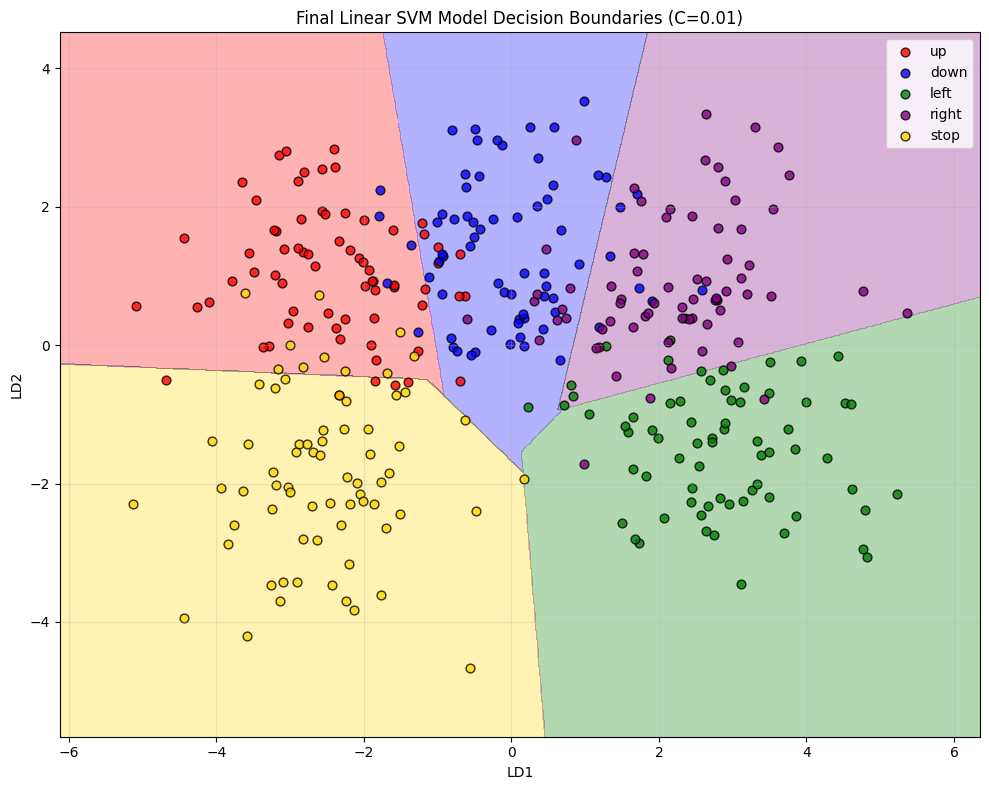

Pipeline Complete. Final SVM and processing models are saved.


In [10]:
import numpy as np
import os
import joblib
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Configuration
DEV_AUDIO_DIR = "recordings"
BEST_C = 0.01
SAMPLE_RATE = 12600
TARGET_LENGTH = 12600
THRESHOLD = 0.02
ROIS = [
    (50, 550), (550, 800), (800, 1050),
    (1200, 1550), (1550, 1800), (1800, 2050),
    (2050, 2300), (5800, 6000), (6000, 6300)
]
COMMANDS_TO_INCLUDE = ['up', 'down', 'left', 'right', 'stop']
FINAL_MODELS_DIR = "final_models"


def preprocess_audio(data, sr, target_sr, threshold, target_length):
    if target_sr and sr != target_sr:
        data = signal.resample(data, int(len(data) * (target_sr / sr)))
    if np.max(np.abs(data)) > 0:
        data = data.astype(np.float32) / np.max(np.abs(data))
    win_length = int(target_sr / 2)
    env = np.convolve(np.abs(data), np.ones(win_length) / win_length, mode='same')
    mask = env > threshold
    if np.any(mask):
        idx = np.where(mask)[0]
        data = data[idx[0]: idx[-1] + 1]
    diff = target_length - len(data)
    if diff > 0:
        return np.pad(data, (diff // 2, diff - diff // 2), mode='constant')
    else:
        start = -diff // 2
        return data[start:start + target_length]

def extract_features(processed_signals, sr, rois):
    features = []
    for signal_data in processed_signals:
        n = len(signal_data)
        yf = fft(signal_data)
        freq = np.fft.fftfreq(n, d=1/sr)[:n//2]
        mag = (2.0 / n) * np.abs(yf[:n//2])
        
        sample_features = []
        for min_f, max_f in rois:
            roi_mask = (freq >= min_f) & (freq < max_f)
            roi_mag = mag[roi_mask]
            
            eps = 1e-10
            if roi_mag.size > 0:
                sample_features.append(np.log(np.mean(roi_mag) + eps))
                sample_features.append(np.log(np.std(roi_mag) + eps))
                sample_features.append(np.log(np.max(roi_mag) + eps))
                sample_features.append(np.log(np.sum(roi_mag**2) + eps))
            else:
                sample_features.extend([np.log(eps)] * 4)
        features.append(sample_features)
    return np.array(features)

def plot_final_decision_boundary(X_lda, y, svm_model, commands_list):
    """Generates and displays the decision boundary plot for the final model."""
    plt.figure(figsize=(10, 8))
    
    full_color_map = {'up': 'red', 'down': 'blue', 'left': 'green', 'right': 'purple', 'stop': 'gold'}
    colors_to_use = [full_color_map.get(cmd, 'black') for cmd in commands_list]
    cmap = ListedColormap(colors_to_use)
    
    h = 0.01
    x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
    y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=len(commands_list)-1)
    
    for i, command in enumerate(commands_list):
        mask = y == i
        plt.scatter(X_lda[mask, 0], X_lda[mask, 1],
                      color=colors_to_use[i], label=command, 
                      alpha=0.8, marker='o', s=40, edgecolor='k')
    
    plt.title(f'Final Linear SVM Model Decision Boundaries (C={svm_model.C})')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def train_and_save_final_svm():
    """Trains the final SVM model on all development data and saves it."""
    # Load and preprocess all audio from the development folder
    processed_signals, commands = [], []
    if not os.path.exists(DEV_AUDIO_DIR):
        print(f"ERROR: The directory '{DEV_AUDIO_DIR}' was not found.")
        return

    for root, _, files in os.walk(DEV_AUDIO_DIR):
        for filename in files:
            if filename.lower().endswith(".wav"):
                filepath = os.path.join(root, filename)
                sr, data = wavfile.read(filepath)
                processed_signals.append(preprocess_audio(data, sr, SAMPLE_RATE, THRESHOLD, TARGET_LENGTH))
                commands.append(filename.split('.')[-2].split('_')[-1])

    if not processed_signals:
        print(f"ERROR: No .wav files were found in '{DEV_AUDIO_DIR}'.")
        return

    # Extract Features
    X_full_dev = extract_features(processed_signals, SAMPLE_RATE, ROIS)
    label_map = {cmd: i for i, cmd in enumerate(COMMANDS_TO_INCLUDE)}
    y_full_dev = np.array([label_map[cmd] for cmd in commands])
    
    # Train Scaler and LDA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full_dev)
    lda = LDA(n_components=2)
    X_lda = lda.fit_transform(X_scaled, y_full_dev)

    # Train the final SVM model
    final_svm_model = SVC(kernel='linear', C=BEST_C)
    final_svm_model.fit(X_lda, y_full_dev)
    
    # Visualize the final trained model
    plot_final_decision_boundary(X_lda, y_full_dev, final_svm_model, COMMANDS_TO_INCLUDE)

    # Save the final models
    os.makedirs(FINAL_MODELS_DIR, exist_ok=True)
    joblib.dump(scaler, os.path.join(FINAL_MODELS_DIR, "scaler.pkl"))
    joblib.dump(lda, os.path.join(FINAL_MODELS_DIR, "lda.pkl"))
    joblib.dump(final_svm_model, os.path.join(FINAL_MODELS_DIR, "svm_model.pkl"))
    # Also save the command list for consistency
    np.save(os.path.join(FINAL_MODELS_DIR, "commands_list.npy"), np.array(COMMANDS_TO_INCLUDE))
    
    print("Pipeline Complete. Final SVM and processing models are saved.")


if __name__ == "__main__":
    train_and_save_final_svm()

## Trained SVM Model used to predict test data


                 FINAL SVM PERFORMANCE REPORT
Test Set Size: 250 samples
Final Accuracy: 0.7480 (74.80%)

Detailed Classification Report:
              precision    recall  f1-score   support

          up       0.82      0.74      0.78        50
        down       0.64      0.60      0.62        50
        left       0.83      0.96      0.89        50
       right       0.67      0.74      0.70        50
        stop       0.78      0.70      0.74        50

    accuracy                           0.75       250
   macro avg       0.75      0.75      0.75       250
weighted avg       0.75      0.75      0.75       250



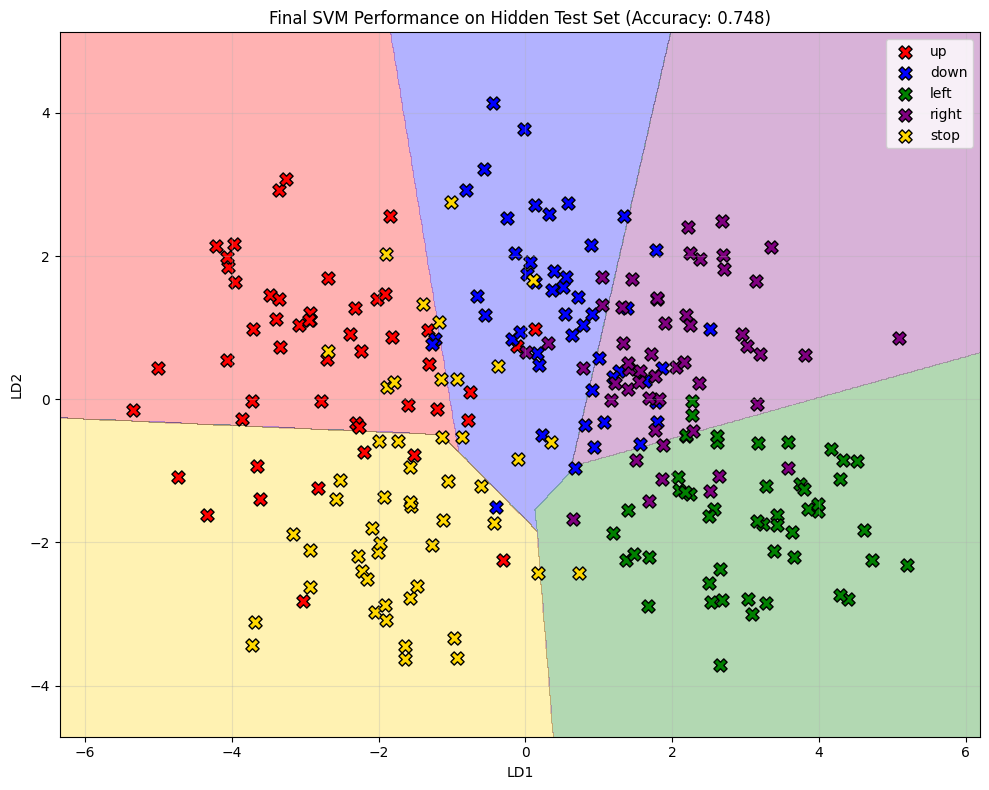

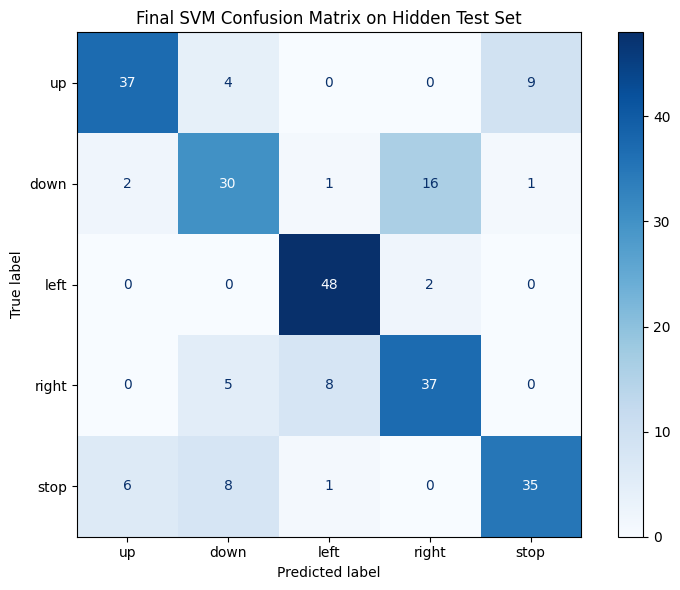

In [11]:
import numpy as np
import os
import joblib
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from matplotlib.colors import ListedColormap

# Configuration
TEST_AUDIO_DIR = "TEST"
FINAL_MODELS_DIR = "final_models"

# Pipeline parameters (MUST MATCH the training script EXACTLY)
SAMPLE_RATE = 12600
TARGET_LENGTH = 12600
THRESHOLD = 0.02
ROIS = [
    (50, 550), (550, 800), (800, 1050),
    (1200, 1550), (1550, 1800), (1800, 2050),
    (2050, 2300), (5800, 6000), (6000, 6300)
]


def preprocess_audio(data, sr, target_sr, threshold, target_length):
    if target_sr and sr != target_sr:
        data = signal.resample(data, int(len(data) * (target_sr / sr)))
    if np.max(np.abs(data)) > 0:
        data = data.astype(np.float32) / np.max(np.abs(data))
    win_length = int(target_sr / 2)
    env = np.convolve(np.abs(data), np.ones(win_length) / win_length, mode='same')
    mask = env > threshold
    if np.any(mask):
        idx = np.where(mask)[0]
        data = data[idx[0]: idx[-1] + 1]
    diff = target_length - len(data)
    if diff > 0:
        return np.pad(data, (diff // 2, diff - diff // 2), mode='constant')
    else:
        start = -diff // 2
        return data[start:start + target_length]

def extract_features(processed_signals, sr, rois):
    features = []
    for signal_data in processed_signals:
        n = len(signal_data)
        yf = fft(signal_data)
        freq = np.fft.fftfreq(n, d=1/sr)[:n//2]
        mag = (2.0 / n) * np.abs(yf[:n//2])
        
        sample_features = []
        for min_f, max_f in rois:
            roi_mask = (freq >= min_f) & (freq < max_f)
            roi_mag = mag[roi_mask]
            
            eps = 1e-10
            if roi_mag.size > 0:
                sample_features.append(np.log(np.mean(roi_mag) + eps))
                sample_features.append(np.log(np.std(roi_mag) + eps))
                sample_features.append(np.log(np.max(roi_mag) + eps))
                sample_features.append(np.log(np.sum(roi_mag**2) + eps))
            else:
                sample_features.extend([np.log(eps)] * 4)
        features.append(sample_features)
    return np.array(features)

def plot_test_set_on_boundaries(svm_model, X_test_lda, y_test_true, commands_list, final_accuracy):
    plt.figure(figsize=(10, 8))
    
    full_color_map = {'up': 'red', 'down': 'blue', 'left': 'green', 'right': 'purple', 'stop': 'gold'}
    colors_to_use = [full_color_map.get(cmd, 'black') for cmd in commands_list]
    cmap = ListedColormap(colors_to_use)
    
    h = 0.01
    x_min, x_max = X_test_lda[:, 0].min() - 1, X_test_lda[:, 0].max() + 1
    y_min, y_max = X_test_lda[:, 1].min() - 1, X_test_lda[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=len(commands_list)-1)
    
    for i, command in enumerate(commands_list):
        mask = y_test_true == i
        plt.scatter(
            X_test_lda[mask, 0], X_test_lda[mask, 1],
            c=colors_to_use[i], label=command,
            marker='X', s=90, edgecolor='k', linewidth=1
        )
    
    plt.title(f'Final SVM Performance on Hidden Test Set (Accuracy: {final_accuracy:.3f})')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def evaluate_final_svm_model():
    # Load models
    scaler = joblib.load(os.path.join(FINAL_MODELS_DIR, "scaler.pkl"))
    lda = joblib.load(os.path.join(FINAL_MODELS_DIR, "lda.pkl"))
    svm_model = joblib.load(os.path.join(FINAL_MODELS_DIR, "svm_model.pkl"))
    commands_list = np.load(os.path.join(FINAL_MODELS_DIR, "commands_list.npy"))

    # Process test audio
    test_signals, y_test_true_str = [], []
    for root, _, files in os.walk(TEST_AUDIO_DIR):
        for filename in files:
            if filename.lower().endswith(".wav"):
                filepath = os.path.join(root, filename)
                sr, data = wavfile.read(filepath)
                test_signals.append(preprocess_audio(data, sr, SAMPLE_RATE, THRESHOLD, TARGET_LENGTH))
                y_test_true_str.append(filename.split('.')[-2].split('_')[-1])
    
    if not test_signals:
        print(f"ERROR: No .wav files found in '{TEST_AUDIO_DIR}'.")
        return
    
    # Extract features and apply transformations
    X_test = extract_features(test_signals, SAMPLE_RATE, ROIS)
    X_test_scaled = scaler.transform(X_test)
    X_test_lda = lda.transform(X_test_scaled)
    
    # Make predictions
    y_pred_indices = svm_model.predict(X_test_lda)
    
    # Evaluate results
    label_map = {cmd: i for i, cmd in enumerate(commands_list)}
    y_test_true_indices = np.array([label_map.get(cmd) for cmd in y_test_true_str if cmd in label_map])
    
    final_accuracy = accuracy_score(y_test_true_indices, y_pred_indices)
    
    print("\n" + "="*50)
    print("                 FINAL SVM PERFORMANCE REPORT")
    print("="*50)
    print(f"Test Set Size: {len(y_test_true_indices)} samples")
    print(f"Final Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print("="*50)
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_test_true_indices, y_pred_indices, target_names=commands_list))
    
    # Display plots
    plot_test_set_on_boundaries(svm_model, X_test_lda, y_test_true_indices, commands_list, final_accuracy)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_test_true_indices, y_pred_indices, 
        display_labels=commands_list, 
        cmap='Blues',
        ax=ax
    )
    plt.title("Final SVM Confusion Matrix on Hidden Test Set")
    ax.grid(False)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate_final_svm_model()

## Classifier 3: Decision-Tree Development (Hyperparameter selection)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

--- Decision Tree Tuning Results ---
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1}
Best cross-validation accuracy: 0.8229


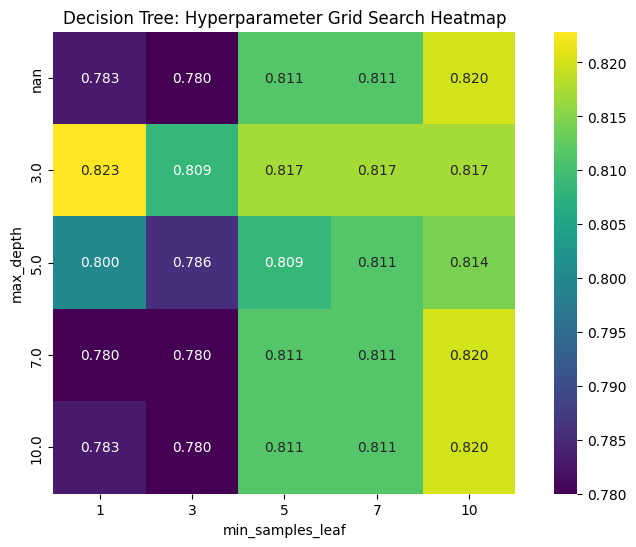

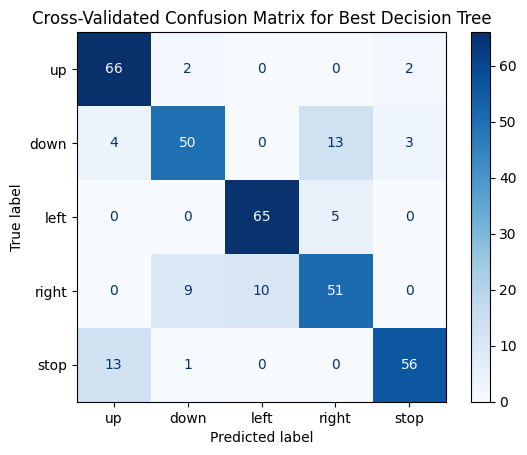

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Load data and extract features
fft_data = np.load("processed_data/fft_features/fft_data.npy", allow_pickle=True)
commands = np.load("npy_data/commands.npy")

label_map = {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'stop': 4}
commands_list = ['up', 'down', 'left', 'right', 'stop']
rois = [
    (50, 500), (550, 800), (800, 1050),
    (1200, 1550), (1550, 1800), (1800, 2050),
    (2050, 2300), (5800, 6000), (6000, 6300)
]

features = []
labels = []
for idx, sample in enumerate(fft_data):
    freq = sample['freq']
    mag = sample['magnitude']
    sample_features = []

    for min_f, max_f in rois:
        roi_mask = (freq >= min_f) & (freq < max_f)
        roi_mag = mag[roi_mask]

        eps = 1e-10
        if roi_mag.size > 0:
            sample_features.append(np.log(np.mean(roi_mag) + eps))
            sample_features.append(np.log(np.std(roi_mag) + eps))
            sample_features.append(np.log(np.max(roi_mag) + eps))
            sample_features.append(np.log(np.sum(roi_mag**2) + eps))
        else:
            sample_features.extend([np.log(eps)] * 4)

    features.append(sample_features)
    labels.append(label_map[commands[idx]])

X = np.array(features)
y = np.array(labels)

# We use the full development set for GridSearchCV, which handles its own internal splits.
# No need for a separate train/validation split at this stage.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lda = LDA(n_components=2)
X_dev = lda.fit_transform(X_scaled, y)
y_dev = y

# Tune Decision Tree hyperparameters
dt_model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 3, 5, 7, 10]
}

grid_search = GridSearchCV(dt_model, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_dev, y_dev)

# Report and visualize results
print("\n--- Decision Tree Tuning Results ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

results_df = pd.DataFrame(grid_search.cv_results_)
pivot_table = results_df.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
pivot_table.index = pivot_table.index.map(lambda x: 'Unlimited' if x is None else x)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis", square=True)
plt.title('Decision Tree: Hyperparameter Grid Search Heatmap')
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.show()

best_estimator = grid_search.best_estimator_
y_pred_cv = cross_val_predict(best_estimator, X_dev, y_dev, cv=5)

ConfusionMatrixDisplay.from_predictions(
    y_dev,
    y_pred_cv,
    display_labels=commands_list,
    cmap='Blues'
)
plt.title('Cross-Validated Confusion Matrix for Best Decision Tree')
plt.show()

## Decision Tree Model training on all 350 voice commands

--- Starting Final Decision Tree Model Training Pipeline ---
Step 1: Loading and preprocessing audio from 'recordings'...
Step 2: Extracting features from all 350 signals...
Step 3: Training Scaler and LDA on all 350 samples...
Step 4: Training final Decision Tree with params: {'max_depth': 3, 'min_samples_leaf': 1}...
Step 5: Generating final decision boundary plot...


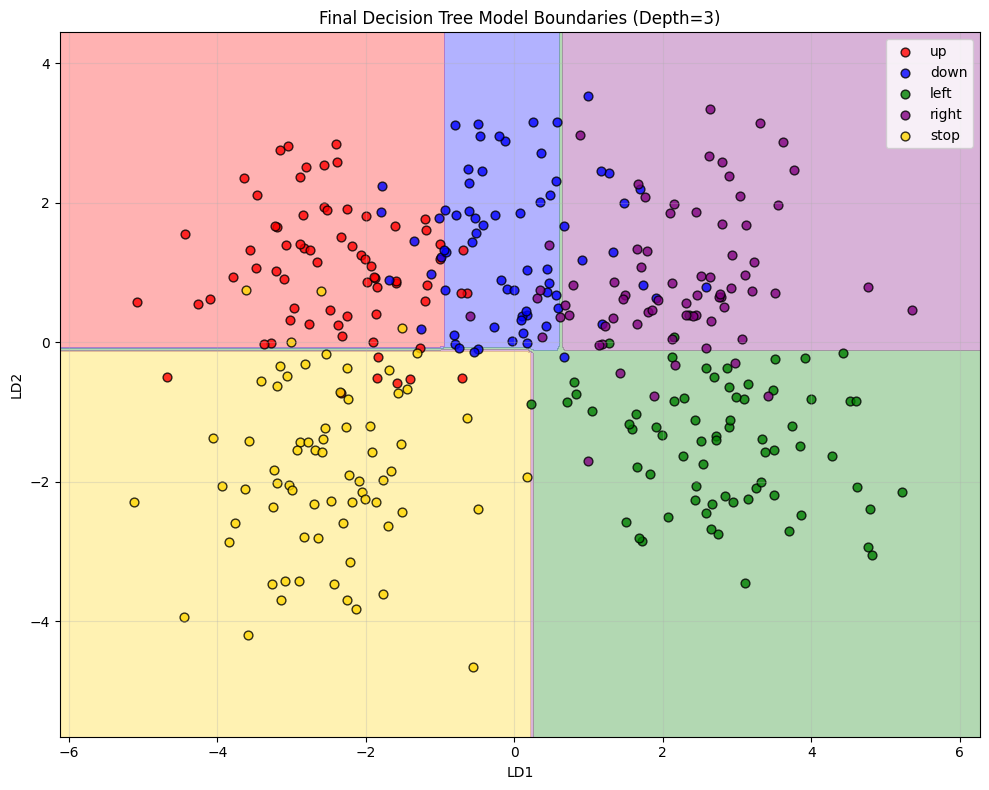

Step 6: Saving final models to 'final_models'...

--- Pipeline Complete. Final models are saved and ready for the test set. ---


In [13]:
import numpy as np
import os
import joblib
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- CONFIGURATION ---
DEV_AUDIO_DIR = "recordings"

# Best hyperparameters found from your tuning step
BEST_DT_PARAMS = {'max_depth': 3, 'min_samples_leaf': 1}

# Your chosen pipeline parameters
SAMPLE_RATE = 12600
TARGET_LENGTH = 12600
THRESHOLD = 0.02
ROIS = [
    (50, 550), (550, 800), (800, 1050), 
    (1200, 1550), (1550, 1800), (1800, 2050),  
    (2050, 2300), (5800, 6000), (6000, 6300)
]
COMMANDS_TO_INCLUDE = ['up', 'down', 'left', 'right', 'stop']
FINAL_MODELS_DIR = "final_models"
# --- END OF CONFIGURATION ---


def preprocess_audio(data, sr, target_sr, threshold, target_length):
    if target_sr and sr != target_sr:
        data = signal.resample(data, int(len(data) * (target_sr / sr)))
    if np.max(np.abs(data)) > 0:
        data = data.astype(np.float32) / np.max(np.abs(data))
    win_length = int(target_sr / 2)
    env = np.convolve(np.abs(data), np.ones(win_length) / win_length, mode='same')
    mask = env > threshold
    if np.any(mask):
        idx = np.where(mask)[0]
        data = data[idx[0]: idx[-1] + 1]
    diff = target_length - len(data)
    if diff > 0:
        return np.pad(data, (diff // 2, diff - diff // 2), mode='constant')
    else:
        start = -diff // 2
        return data[start:start + target_length]

def extract_features(processed_signals, sr, rois):
    features = []
    for signal_data in processed_signals:
        n = len(signal_data)
        yf = fft(signal_data)
        freq = np.fft.fftfreq(n, d=1/sr)[:n//2]
        mag = (2.0 / n) * np.abs(yf[:n//2])
        
        sample_features = []
        for min_f, max_f in rois:
            roi_mask = (freq >= min_f) & (freq < max_f)
            roi_mag = mag[roi_mask]
            
            eps = 1e-10
            if roi_mag.size > 0:
                sample_features.append(np.log(np.mean(roi_mag) + eps))
                sample_features.append(np.log(np.std(roi_mag) + eps))
                sample_features.append(np.log(np.max(roi_mag) + eps))
                sample_features.append(np.log(np.sum(roi_mag**2) + eps))
            else:
                sample_features.extend([np.log(eps)] * 4)
        features.append(sample_features)
    return np.array(features)

def plot_final_decision_boundary(X_lda, y, dt_model, commands_list):
    print("Step 5: Generating final decision boundary plot...")
    plt.figure(figsize=(10, 8))
    
    full_color_map = {'up': 'red', 'down': 'blue', 'left': 'green', 'right': 'purple', 'stop': 'gold'}
    colors_to_use = [full_color_map.get(cmd, 'black') for cmd in commands_list]
    cmap = ListedColormap(colors_to_use)
    
    h = 0.1
    x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
    y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = dt_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=len(commands_list)-1)
    
    for i, command in enumerate(commands_list):
        mask = y == i
        plt.scatter(X_lda[mask, 0], X_lda[mask, 1],
                    color=colors_to_use[i], label=command, 
                    alpha=0.8, marker='o', s=40, edgecolor='k')
    
    plt.title(f'Final Decision Tree Model Boundaries (Depth={dt_model.max_depth})')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def train_final_model():
    print("--- Starting Final Decision Tree Model Training Pipeline ---")
    
    print(f"Step 1: Loading and preprocessing audio from '{DEV_AUDIO_DIR}'...")
    processed_signals, commands = [], []
    for root, _, files in os.walk(DEV_AUDIO_DIR):
        for filename in files:
            if filename.lower().endswith(".wav"):
                filepath = os.path.join(root, filename)
                sr, data = wavfile.read(filepath)
                processed_signals.append(preprocess_audio(data, sr, SAMPLE_RATE, THRESHOLD, TARGET_LENGTH))
                commands.append(filename.split('.')[-2].split('_')[-1])

    if not processed_signals:
        print(f"ERROR: No .wav files found in '{DEV_AUDIO_DIR}'.")
        return
    
    print(f"Step 2: Extracting features from all {len(processed_signals)} signals...")
    X_full_dev = extract_features(processed_signals, SAMPLE_RATE, ROIS)
    label_map = {cmd: i for i, cmd in enumerate(COMMANDS_TO_INCLUDE)}
    y_full_dev = np.array([label_map[cmd] for cmd in commands])
    
    print(f"Step 3: Training Scaler and LDA on all {len(X_full_dev)} samples...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full_dev)
    lda = LDA(n_components=2)
    X_lda = lda.fit_transform(X_scaled, y_full_dev)

    print(f"Step 4: Training final Decision Tree with params: {BEST_DT_PARAMS}...")
    # The ** operator unpacks the dictionary of best parameters
    dt_final = DecisionTreeClassifier(**BEST_DT_PARAMS, random_state=42)
    dt_final.fit(X_lda, y_full_dev)
    
    plot_final_decision_boundary(X_lda, y_full_dev, dt_final, COMMANDS_TO_INCLUDE)
    
    print(f"Step 6: Saving final models to '{FINAL_MODELS_DIR}'...")
    os.makedirs(FINAL_MODELS_DIR, exist_ok=True)
    joblib.dump(scaler, os.path.join(FINAL_MODELS_DIR, "scaler.pkl"))
    joblib.dump(lda, os.path.join(FINAL_MODELS_DIR, "lda.pkl"))
    joblib.dump(dt_final, os.path.join(FINAL_MODELS_DIR, "dt_model.pkl"))
    np.save(os.path.join(FINAL_MODELS_DIR, "commands_list.npy"), np.array(COMMANDS_TO_INCLUDE))
    
    print("\n--- Pipeline Complete. Final models are saved and ready for the test set. ---")

if __name__ == "__main__":
    train_final_model()


## Trained Decision Tree Model used to predict test data


           FINAL DECISION TREE PERFORMANCE REPORT
Test Set Size: 250 samples
Final Accuracy: 0.7160 (71.60%)

Detailed Classification Report:
              precision    recall  f1-score   support

          up       0.76      0.64      0.70        50
        down       0.74      0.46      0.57        50
        left       0.72      0.98      0.83        50
       right       0.68      0.76      0.72        50
        stop       0.70      0.74      0.72        50

    accuracy                           0.72       250
   macro avg       0.72      0.72      0.71       250
weighted avg       0.72      0.72      0.71       250



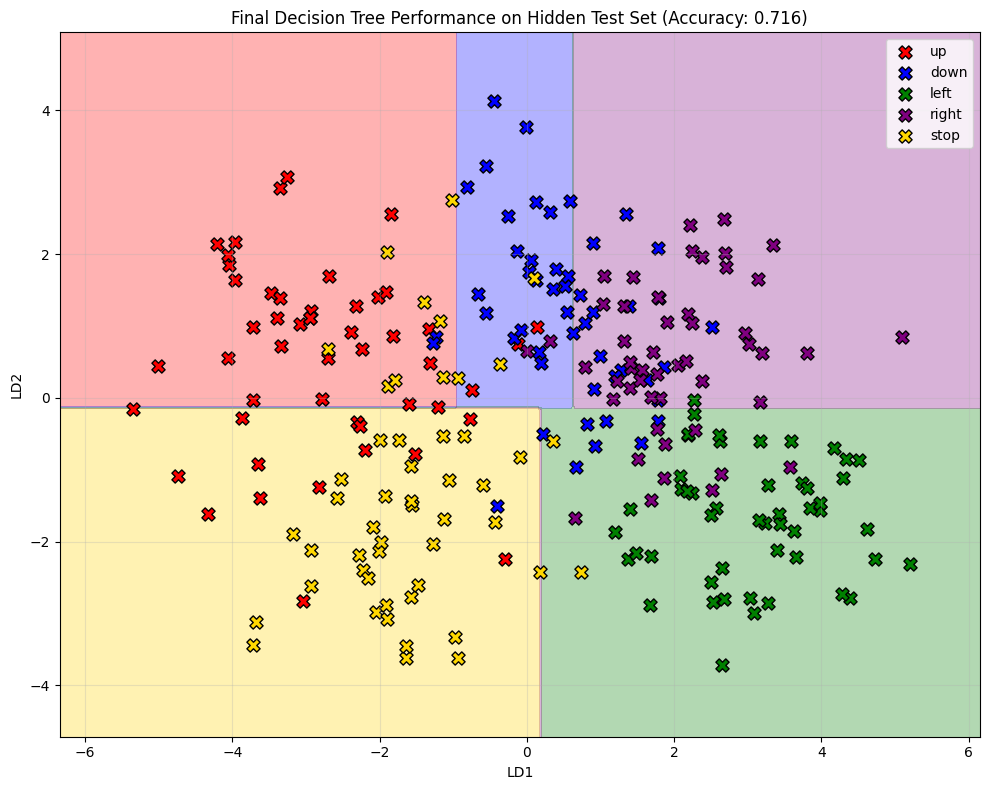

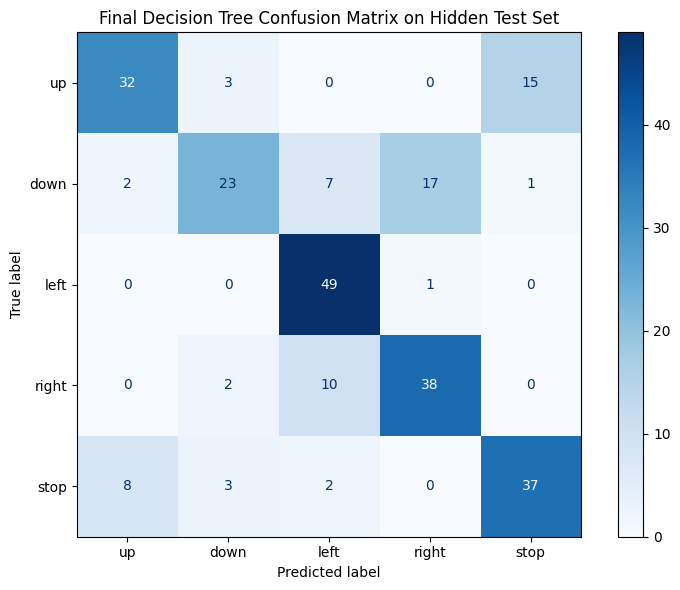

In [14]:
import numpy as np
import os
import joblib
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from matplotlib.colors import ListedColormap

# Configuration
TEST_AUDIO_DIR = "TEST"
FINAL_MODELS_DIR = "final_models"
SAMPLE_RATE = 12600
TARGET_LENGTH = 12600
THRESHOLD = 0.02
ROIS = [
    (50, 550), (550, 800), (800, 1050),
    (1200, 1550), (1550, 1800), (1800, 2050),
    (2050, 2300), (5800, 6000), (6000, 6300)
]


def preprocess_audio(data, sr, target_sr, threshold, target_length):
    if target_sr and sr != target_sr:
        data = signal.resample(data, int(len(data) * (target_sr / sr)))
    if np.max(np.abs(data)) > 0:
        data = data.astype(np.float32) / np.max(np.abs(data))
    win_length = int(target_sr / 2)
    env = np.convolve(np.abs(data), np.ones(win_length) / win_length, mode='same')
    mask = env > threshold
    if np.any(mask):
        idx = np.where(mask)[0]
        data = data[idx[0]: idx[-1] + 1]
    diff = target_length - len(data)
    if diff > 0:
        return np.pad(data, (diff // 2, diff - diff // 2), mode='constant')
    else:
        start = -diff // 2
        return data[start:start + target_length]

def extract_features(processed_signals, sr, rois):
    features = []
    for signal_data in processed_signals:
        n = len(signal_data)
        yf = fft(signal_data)
        freq = np.fft.fftfreq(n, d=1/sr)[:n//2]
        mag = (2.0 / n) * np.abs(yf[:n//2])
        
        sample_features = []
        for min_f, max_f in rois:
            roi_mask = (freq >= min_f) & (freq < max_f)
            roi_mag = mag[roi_mask]
            
            eps = 1e-10
            if roi_mag.size > 0:
                sample_features.append(np.log(np.mean(roi_mag) + eps))
                sample_features.append(np.log(np.std(roi_mag) + eps))
                sample_features.append(np.log(np.max(roi_mag) + eps))
                sample_features.append(np.log(np.sum(roi_mag**2) + eps))
            else:
                sample_features.extend([np.log(eps)] * 4)
        features.append(sample_features)
    return np.array(features)

def plot_test_set_on_boundaries(dt_model, X_test_lda, y_test_true, commands_list, final_accuracy):
    plt.figure(figsize=(10, 8))
    
    full_color_map = {'up': 'red', 'down': 'blue', 'left': 'green', 'right': 'purple', 'stop': 'gold'}
    colors_to_use = [full_color_map.get(cmd, 'black') for cmd in commands_list]
    cmap = ListedColormap(colors_to_use)
    
    h = 0.05
    x_min, x_max = X_test_lda[:, 0].min() - 1, X_test_lda[:, 0].max() + 1
    y_min, y_max = X_test_lda[:, 1].min() - 1, X_test_lda[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = dt_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=len(commands_list)-1)
    
    for i, command in enumerate(commands_list):
        mask = y_test_true == i
        plt.scatter(
            X_test_lda[mask, 0], X_test_lda[mask, 1],
            c=colors_to_use[i], label=command,
            marker='X', s=90, edgecolor='k', linewidth=1
        )
    
    plt.title(f'Final Decision Tree Performance on Hidden Test Set (Accuracy: {final_accuracy:.3f})')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def evaluate_final_dt_model():
    # Load models
    scaler = joblib.load(os.path.join(FINAL_MODELS_DIR, "scaler.pkl"))
    lda = joblib.load(os.path.join(FINAL_MODELS_DIR, "lda.pkl"))
    dt_model = joblib.load(os.path.join(FINAL_MODELS_DIR, "dt_model.pkl"))
    commands_list = np.load(os.path.join(FINAL_MODELS_DIR, "commands_list.npy"))

    # Process test audio
    test_signals, y_test_true_str = [], []
    for root, _, files in os.walk(TEST_AUDIO_DIR):
        for filename in files:
            if filename.lower().endswith(".wav"):
                filepath = os.path.join(root, filename)
                sr, data = wavfile.read(filepath)
                test_signals.append(preprocess_audio(data, sr, SAMPLE_RATE, THRESHOLD, TARGET_LENGTH))
                y_test_true_str.append(filename.split('.')[-2].split('_')[-1])
    
    if not test_signals:
        print(f"ERROR: No .wav files found in '{TEST_AUDIO_DIR}'.")
        return
    
    # Extract features and apply transformations
    X_test = extract_features(test_signals, SAMPLE_RATE, ROIS)
    X_test_scaled = scaler.transform(X_test)
    X_test_lda = lda.transform(X_test_scaled)
    
    # Make predictions
    y_pred_indices = dt_model.predict(X_test_lda)
    
    # Evaluate results
    label_map = {cmd: i for i, cmd in enumerate(commands_list)}
    y_test_true_indices = np.array([label_map[cmd] for cmd in y_test_true_str])
    
    final_accuracy = accuracy_score(y_test_true_indices, y_pred_indices)
    
    print("\n" + "="*50)
    print("           FINAL DECISION TREE PERFORMANCE REPORT")
    print("="*50)
    print(f"Test Set Size: {len(y_test_true_indices)} samples")
    print(f"Final Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print("="*50)
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_test_true_indices, y_pred_indices, 
                                target_names=commands_list))
    
    # Display the final plots
    plot_test_set_on_boundaries(dt_model, X_test_lda, y_test_true_indices, commands_list, final_accuracy)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_test_true_indices, y_pred_indices, 
        display_labels=commands_list, 
        cmap='Blues',
        ax=ax
    )
    plt.title("Final Decision Tree Confusion Matrix on Hidden Test Set")
    ax.grid(False)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate_final_dt_model()

## Live Classification

In [15]:
import numpy as np
import os
import joblib
import pyaudio
import wave
from scipy import signal
from scipy.fft import fft
import threading
import time
import queue
import pygame

# --- CONFIGURATION ---
FINAL_MODELS_DIR = "final_models"
SAMPLE_RATE = 12600
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
WAVE_OUTPUT_FILENAME = "temp_recording.wav"

# --- NEW: ADVANCED VAD SETTINGS ---
# You will need to tune these for your microphone and environment.
# A good starting point is to have START be higher than END.
VAD_START_THRESHOLD = 2000  # Energy level to start recording.
VAD_END_THRESHOLD = 1000    # Energy level to consider as silence.
SILENCE_TIMEOUT_SECONDS = 0.8 # How many seconds of silence ends the recording.

# Game settings
WINDOW_SIZE = (600, 600)
BACKGROUND_COLOR = (0, 0, 0)
PACMAN_COLOR = (255, 255, 0)
DOT_COLOR = (255, 255, 255)
PACMAN_SPEED = 5
# --- END OF CONFIGURATION ---


# --- DATA PROCESSING PIPELINE ---
TARGET_LENGTH = 12600
PREPROCESS_THRESHOLD = 0.02
ROIS = [
    (50, 550), (550, 800), (800, 1050), 
    (1200, 1550), (1550, 1800), (1800, 2050),  
    (2050, 2300), (5800, 6000), (6000, 6300)
]

def preprocess_audio(data, sr, target_sr, threshold, target_length):
    if target_sr and sr != target_sr:
        data = signal.resample(data, int(len(data) * (target_sr / sr)))
    if np.max(np.abs(data)) > 0:
        data = data.astype(np.float32) / np.max(np.abs(data))
    win_length = int(target_sr / 2)
    env = np.convolve(np.abs(data), np.ones(win_length) / win_length, mode='same')
    mask = env > threshold
    if np.any(mask):
        idx = np.where(mask)[0]
        data = data[idx[0]: idx[-1] + 1]
    diff = target_length - len(data)
    if diff > 0:
        return np.pad(data, (diff // 2, diff - diff // 2), mode='constant')
    else:
        start = -diff // 2
        return data[start:start + target_length]

def extract_features(processed_signals, sr, rois):
    features = []
    if not isinstance(processed_signals, list):
        processed_signals = [processed_signals]

    for signal_data in processed_signals:
        n = len(signal_data)
        yf = fft(signal_data)
        freq = np.fft.fftfreq(n, d=1/sr)[:n//2]
        mag = (2.0 / n) * np.abs(yf[:n//2])
        
        sample_features = []
        for min_f, max_f in rois:
            roi_mask = (freq >= min_f) & (freq < max_f)
            roi_mag = mag[roi_mask]
            
            eps = 1e-10
            if roi_mag.size > 0:
                sample_features.append(np.log(np.mean(roi_mag) + eps))
                sample_features.append(np.log(np.std(roi_mag) + eps))
                sample_features.append(np.log(np.max(roi_mag) + eps))
                sample_features.append(np.log(np.sum(roi_mag**2) + eps))
            else:
                sample_features.extend([np.log(eps)] * 4)
        features.append(sample_features)
    return np.array(features)

# --- LIVE CLASSIFICATION THREAD ---
class AudioClassifier(threading.Thread):
    def __init__(self, command_queue):
        super().__init__()
        self.command_queue = command_queue
        self._stop_event = threading.Event()

        print("Loading trained models...")
        self.scaler = joblib.load(os.path.join(FINAL_MODELS_DIR, "scaler.pkl"))
        self.lda = joblib.load(os.path.join(FINAL_MODELS_DIR, "lda.pkl"))
        self.model = joblib.load(os.path.join(FINAL_MODELS_DIR, "knn_model.pkl"))
        self.commands_list = np.load(os.path.join(FINAL_MODELS_DIR, "commands_list.npy"))
        print("Models loaded successfully.")

        self.audio = pyaudio.PyAudio()
        self.stream = self.audio.open(format=FORMAT, channels=CHANNELS,
                                      rate=SAMPLE_RATE, input=True,
                                      frames_per_buffer=CHUNK)

    def stop(self):
        self._stop_event.set()

    def run(self):
        print("Listening for commands...")
        recording = False
        utterance_frames = []
        silence_chunks = 0
        silence_timeout_chunks = int(SILENCE_TIMEOUT_SECONDS * (SAMPLE_RATE / CHUNK))

        while not self._stop_event.is_set():
            data = self.stream.read(CHUNK, exception_on_overflow=False)
            if not data: continue

            audio_data_int = np.frombuffer(data, dtype=np.int16)
            if audio_data_int.size == 0: continue
            
            energy = np.sqrt(np.mean(audio_data_int.astype(np.float64)**2))

            if not recording:
                if energy > VAD_START_THRESHOLD:
                    print(f"Speech started! (Energy: {energy:.2f})")
                    recording = True
                    utterance_frames.append(data)
            else: # We are currently recording
                utterance_frames.append(data)
                if energy < VAD_END_THRESHOLD:
                    silence_chunks += 1
                    if silence_chunks > silence_timeout_chunks:
                        print("Speech ended.")
                        recording = False
                        silence_chunks = 0

                        # Process the complete utterance
                        with wave.open(WAVE_OUTPUT_FILENAME, 'wb') as wf:
                            wf.setnchannels(CHANNELS)
                            wf.setsampwidth(self.audio.get_sample_size(FORMAT))
                            wf.setframerate(SAMPLE_RATE)
                            wf.writeframes(b''.join(utterance_frames))
                        
                        utterance_frames = [] # Clear for next time

                        sr, audio_data = wavfile.read(WAVE_OUTPUT_FILENAME)
                        processed_signal = preprocess_audio(audio_data, sr, SAMPLE_RATE, PREPROCESS_THRESHOLD, TARGET_LENGTH)
                        
                        features = extract_features([processed_signal], SAMPLE_RATE, ROIS)
                        features_scaled = self.scaler.transform(features)
                        features_lda = self.lda.transform(features_scaled)
                        prediction_index = self.model.predict(features_lda)[0]
                        command = self.commands_list[prediction_index]
                        
                        print(f"--> Predicted Command: {command.upper()}")
                        self.command_queue.put(command)
                else:
                    # Still speaking, reset silence counter
                    silence_chunks = 0

        self.stream.stop_stream()
        self.stream.close()
        self.audio.terminate()
        print("Audio thread stopped.")

# --- PYGAME PAC-MAN GAME ---
def game_loop(command_queue):
    pygame.init()
    screen = pygame.display.set_mode(WINDOW_SIZE)
    pygame.display.set_caption("Live Command Pac-Man")
    clock = pygame.time.Clock()

    pacman_pos = [WINDOW_SIZE[0] // 2, WINDOW_SIZE[1] // 2]
    pacman_vel = [0, 0]

    dots = [pygame.Rect(x, y, 10, 10) for x in range(50, WINDOW_SIZE[0] - 50, 50) for y in range(50, WINDOW_SIZE[1] - 50, 50)]
    score = 0
    font = pygame.font.Font(None, 36)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        if not command_queue.empty():
            command = command_queue.get()
            if command == 'up': pacman_vel = [0, -PACMAN_SPEED]
            elif command == 'down': pacman_vel = [0, PACMAN_SPEED]
            elif command == 'left': pacman_vel = [-PACMAN_SPEED, 0]
            elif command == 'right': pacman_vel = [PACMAN_SPEED, 0]
            elif command == 'stop': pacman_vel = [0, 0]

        pacman_pos[0] = (pacman_pos[0] + pacman_vel[0]) % WINDOW_SIZE[0]
        pacman_pos[1] = (pacman_pos[1] + pacman_vel[1]) % WINDOW_SIZE[1]

        pacman_rect = pygame.Rect(pacman_pos[0] - 15, pacman_pos[1] - 15, 30, 30)
        for dot in dots[:]:
            if pacman_rect.colliderect(dot):
                dots.remove(dot)
                score += 10
        
        screen.fill(BACKGROUND_COLOR)
        for dot in dots:
            pygame.draw.ellipse(screen, DOT_COLOR, dot)
        pygame.draw.circle(screen, PACMAN_COLOR, (int(pacman_pos[0]), int(pacman_pos[1])), 15)
        score_text = font.render(f"Score: {score}", True, (255, 255, 255))
        screen.blit(score_text, (10, 10))
        
        pygame.display.flip()
        clock.tick(30)

    pygame.quit()
    print("Game loop stopped.")

# --- MAIN EXECUTION ---
if __name__ == '__main__':
    command_queue = queue.Queue()
    audio_thread = AudioClassifier(command_queue)
    audio_thread.start()

    try:
        game_loop(command_queue)
    finally:
        audio_thread.stop()
        audio_thread.join()
        print("Application shut down cleanly.")



C:\Users\syedm\Desktop\RPTU\Sensor Signal Processing\Final Submission SSP SS25\env\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.13.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading trained models...
Models loaded successfully.
Listening for commands...
Speech started! (Energy: 6643.88)
Speech ended.
--> Predicted Command: DOWN
Speech started! (Energy: 6569.31)
Speech ended.
--> Predicted Command: UP
Speech started! (Energy: 5788.31)
Speech ended.
--> Predicted Command: LEFT
Speech started! (Energy: 7584.66)
Speech ended.
--> Predicted Command: LEFT
Speech started! (Energy: 2115.13)
Speech ended.
--> Predicted Command: LEFT
Speech started! (Energy: 8313.39)
Speech ended.
--> Predicted Command: DOWN
Game loop stopped.
Audio thread stopped.
Application shut down cleanly.
